# Global Terrorism Database - An exploratory analysis
Matheus Felipe Eduardo Barbosa - 2016058476

## Introduction

Terrorism has been a hot topic in recent years, mainly due to its causes and effects. It is a very delicate subject to deal with today, however, it is an extremely important issue to be addressed and talked about. The growing trend of attacks in the Middle East and North Africa has terrified the residents of those regions and shocked people around the world, showing the urgency of greater attention to this problem.

Thus, it becomes very beneficial to analyze the patterns, results, and trends of past attacks, in order to extract useful information, both as a form of awareness, prevention, and even as a way to inhibit this kind of actions.

This way, it was decided to make a Data Science project to address this proposal.

## Objectives

The study here aims to analyze a database of terrorist attacks that have occurred around the world, and try to draw some insights on the subject.

Mainly, it is intended to focus on descriptive and exploratory analyzes that can better describe the situation of the terrorism over time, and answer some questions such as: How has the rate of attacks behaved? Which areas are most prone to attacks? What are the projections of the groups' actions over time?

To do this, I will mainly rely on data visualization techniques to extract interesting information from all available data types (numbers, text, and geographic data primarily).

## Methodology

In this study I used the open-source database provided by the GTD (Global Terrorism Database) project. This project was created by a team from the University of Maryland, and is maintained by The National Consortium for the Study of Terrorism and Responses to Terrorism (START). They made available an open-source database including information on terrorist events around the world from 1970 through 2017. It includes information on more than 180,000 terrorist attacks, and details such as the attack location, the number of casualties, who took responsibility, and more.

It is available through their website, or through the kaggle platform.

So first of all, these are the libraries that will be needed for the analysis. In summary, among them are some common python libraries, such as numpy, random, math and io, also Pandas and its dataframe implementation to handle data, ntlk and wordcloud for some word processing, and finally matplotlib to do some plots.

In [36]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as ani
import matplotlib.colors as cl
import matplotlib.cm as cm
import matplotlib.image as mpimg
import seaborn as sns; sns.set()
import io,random,base64,nltk,math
from mpl_toolkits.basemap import Basemap
from IPython.display import HTML,Image
from collections import Counter 
from os import path
from PIL import Image
from collections import defaultdict
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

So, using pandas, we can read the GTD .csv file and get a raw dataframe. Here is how the data looks like.

In [3]:
data = pd.read_csv("~/Faculdade/ICD/Projeto/Data/gtd.csv", encoding='ISO-8859-1')

data.head(5)

eventid  iyear  imonth  iday approxdate  extended resolution  country  \
0  197000000001   1970       7     2        NaN         0        NaN       58   
1  197000000002   1970       0     0        NaN         0        NaN      130   
2  197001000001   1970       1     0        NaN         0        NaN      160   
3  197001000002   1970       1     0        NaN         0        NaN       78   
4  197001000003   1970       1     0        NaN         0        NaN      101   

          country_txt  region   ...    addnotes scite1 scite2  scite3  \
0  Dominican Republic       2   ...         NaN    NaN    NaN     NaN   
1              Mexico       1   ...         NaN    NaN    NaN     NaN   
2         Philippines       5   ...         NaN    NaN    NaN     NaN   
3              Greece       8   ...         NaN    NaN    NaN     NaN   
4               Japan       4   ...         NaN    NaN    NaN     NaN   

   dbsource  INT_LOG  INT_IDEO INT_MISC INT_ANY  related  
0      PGIS        0         0        0       0      NaN  
1      PGIS        0         1        1       1      NaN  
2      PGIS       -9        -9        1       1      NaN  
3      PGIS       -9        -9        1       1      NaN  
4      PGIS       -9        -9        1       1      NaN  

[5 rows x 135 columns]

There will be no need for so much data, so a simple cleaning will be necessary. I will extract the columns I will need, and give them a better name. Here we can see the percentage os null values in the dataset. The only collumns that have a representative portion of null values are the ones related to text data. As I won't make any complex analysis with this type of data, there will be no harm on removing the null values. So, I will replace any null values in the frame with zeros, to make some futher analysis easier. 

In [4]:
mapper = {'iyear':'Year' , 'country_txt': 'Country','region_txt': 'Region',
          'latitude':'Latitude', 'longitude':'Longitude',
          'summary':'Summary', 'success':'Success',
          'target1':'Target', 'targtype1_txt':'TargetType',
          'attacktype1_txt':'AttackType', 'gname':'Group',
          'weaptype1_txt':'WeaponType','nkill':'Kills',
          'nwound':'Wounds' , 'motive':'Motive'}

data.rename(columns=mapper,inplace=True);

data = data[['Year' , 'Country', 'Region','Latitude', 'Longitude',
          'Summary', 'Success','Target', 'TargetType',
          'AttackType', 'Group','WeaponType','Kills',
          'Wounds','Motive']]

print('% of nulls\n')
print((data.isnull().sum()/len(data)) * 100)

data.fillna(0,inplace=True)

% of nulls

Year           0.000000
Country        0.000000
Region         0.000000
Latitude       2.507554
Longitude      2.508104
Summary       36.396409
Success        0.000000
Target         0.350045
TargetType     0.000000
AttackType     0.000000
Group          0.000000
WeaponType     0.000000
Kills          5.676120
Wounds         8.977330
Motive        72.171984
dtype: float64


At last, for a better visualization when dealing with attack targets, I will group some of the categories.
I will group them using the following pattern: Bussiness and NGOs will be grouped as Institutions; Both kinds of Governments listed will be joined; Police and Millitary will be joined too; Airports & Aircraft, Maritime and Transportation will be grouped as Transportation attacks; Food or Water Supply, Telecommunication and Utilities will be grouped as Infrastructure attacks; All the other categories will be considered as Individuals.

At the end you can see the definitive version of the dataframe.

In [5]:
targets = []

for attack in data['TargetType'].values:
    if attack in ['Business','NGO']:
        targets.append('Institution')
    elif attack == 'Journalists & Media':
        targets.append('Media')
    elif attack in ['Government (General)', 'Government (Diplomatic)']:
        targets.append('Government')
    elif attack in ['Police','Military']:
        targets.append('Police/Military')
    elif attack == 'Religious Figures/Institutions':
        targets.append('Religious')
    elif attack in ['Airports & Aircraft', 'Maritime', 'Transportation']:
        targets.append('Transportation')
    elif attack in ['Food or Water Supply', 'Telecommunication', 'Utilities']:
        targets.append('Infrastructure')
    elif attack == 'Unknown':
        targets.append('Unknown')
    elif attack == 'Educational Institution':
        targets.append('Educational Institution')
    else:
        targets.append('Individual')

data['TargetType'] = targets

data.head(5)

Year             Country                       Region   Latitude  \
0  1970  Dominican Republic  Central America & Caribbean  18.456792   
1  1970              Mexico                North America  19.371887   
2  1970         Philippines               Southeast Asia  15.478598   
3  1970              Greece               Western Europe  37.997490   
4  1970               Japan                    East Asia  33.580412   

    Longitude Summary  Success                   Target  TargetType  \
0  -69.951164       0        1             Julio Guzman  Individual   
1  -99.086624       0        1  Nadine Chaval, daughter  Government   
2  120.599741       0        1                 Employee       Media   
3   23.762728       0        1             U.S. Embassy  Government   
4  130.396361       0        1           U.S. Consulate  Government   

                       AttackType                               Group  \
0                   Assassination                              MANO-D   
1     Hostage Taking (Kidnapping)  23rd of September Communist League   
2                   Assassination                             Unknown   
3               Bombing/Explosion                             Unknown   
4  Facility/Infrastructure Attack                             Unknown   

   WeaponType  Kills  Wounds Motive  
0     Unknown    1.0     0.0      0  
1     Unknown    0.0     0.0      0  
2     Unknown    1.0     0.0      0  
3  Explosives    0.0     0.0      0  
4  Incendiary    0.0     0.0      0

### Some observations

Some few comments should be considered before showing the results. 

First, due to some infrastructural reasons related to the START organization that maintains the database, there is no data about the year 1993. So, all the plots that have a temporal progression through the years should have a blank space in this year.

Also, there's some incosistency in the proportion of the attacks. The big marjority of the data lays between 2012 and 2017. The START group argues that this is due to a change in the data collection infrastructure, which have been much improved since the 2012.

## Results

Now we can start to find some interesting information among the data. Let's see some of the data available in text form that we have, to see if we find any interesting information. A word cloud will be handy in that matter.

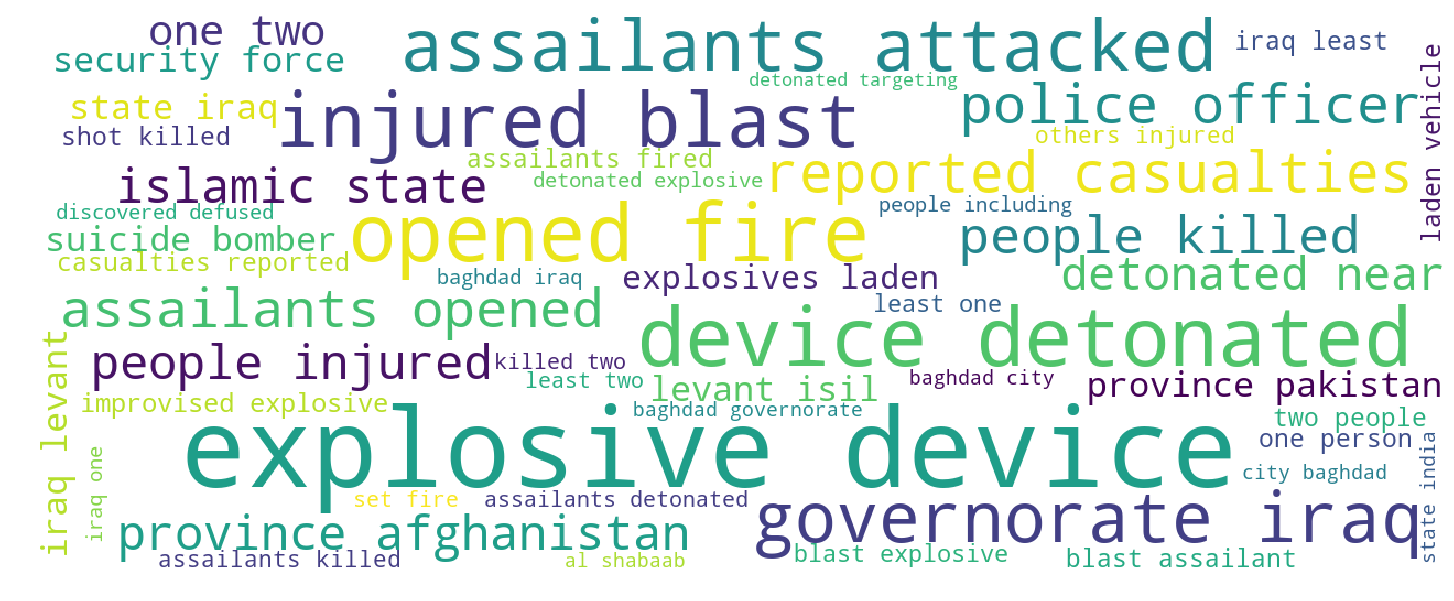

In [6]:
descriptions = []
for description in data["Summary"]:
    if description != 0:
        descriptions.append(description.lower())

words = []
for description in descriptions:
    tokens = nltk.word_tokenize(description)
    words += tokens

stop_words = set(nltk.corpus.stopwords.words('english'))
restricted = ['responsibility','claimed','group','attributed','incident','unknown','specific','motive',
             'attack','sources','trend']
words = [word for word in words if word not in stop_words and word not in restricted and len(word)>2]

wordcloud = WordCloud(max_font_size=100, max_words=50, 
                      background_color="white",width=1280, height=512).generate(" ".join(words))

plt.figure(figsize=(20, 10),facecolor='w' )
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

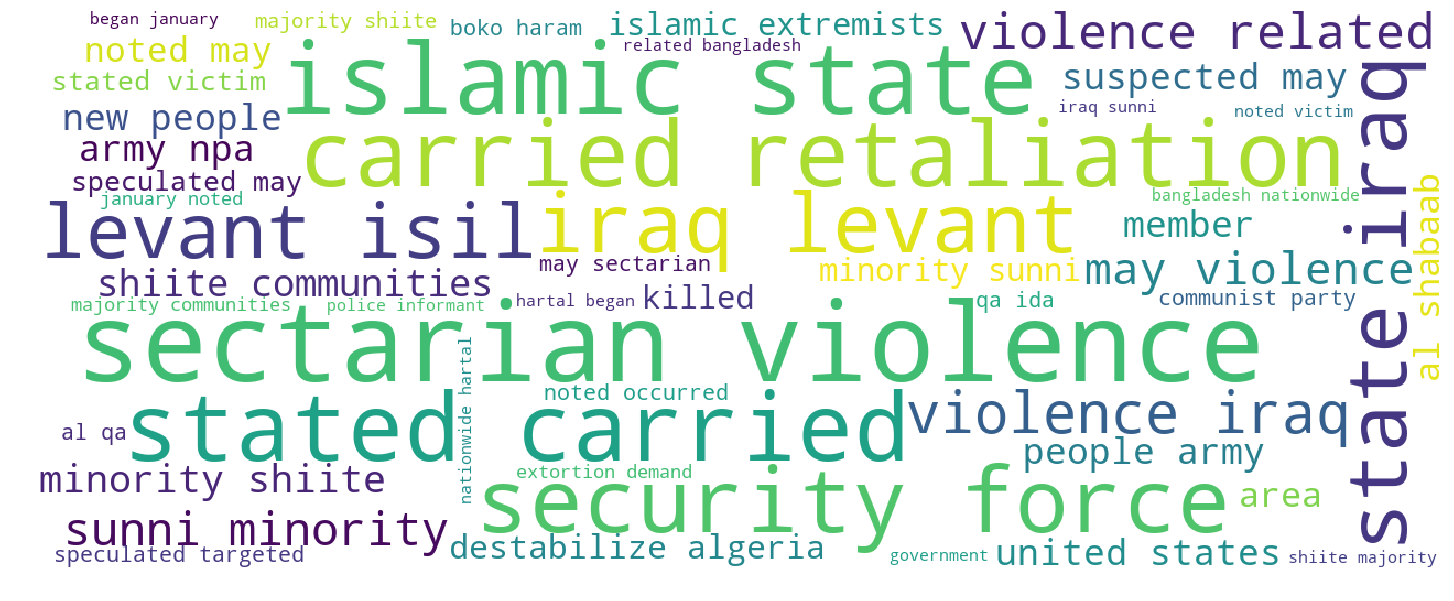

In [7]:
descriptions = []
for description in data["Motive"]:
    if description != 0:
        descriptions.append(description.lower())

words = []
for description in descriptions:
    tokens = nltk.word_tokenize(description)
    words += tokens

stop_words = set(nltk.corpus.stopwords.words('english'))
restricted = ['responsibility','claimed','group','attributed','incident','unknown','specific','motive',
             'attack','sources','trend','part','larger']
words = [word for word in words if word not in stop_words and word not in restricted and len(word)>2]

wordcloud = WordCloud(max_font_size=100, max_words=50, 
                      background_color="white",width=1280, height=512).generate(" ".join(words))

plt.figure(figsize=(20, 10),facecolor='w' )
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

We can see that most frequent words in the summary and the motive behind the attacks, are words related to explosions, victims, violence, and sectarianism. Also, we can see a glance of some groups like ISIS, Boko Haram, and Al shabaab, and some countries like Iraq and India between the words.

Lets now take a deeper look at the data, starting by checking the progression of the attacks along the years.

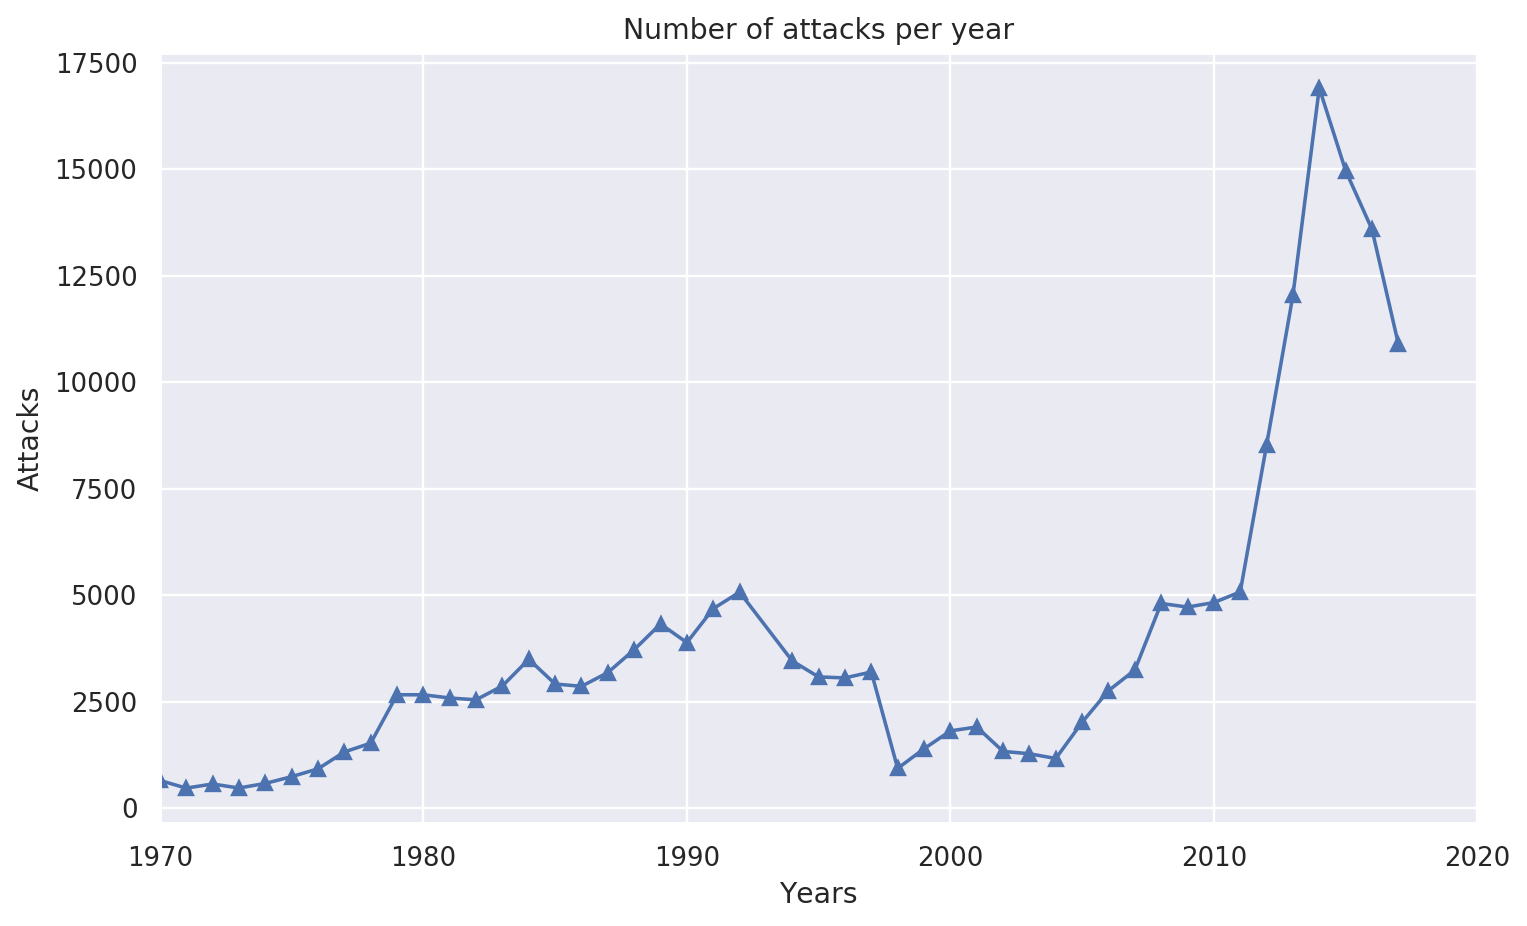

In [8]:
year_count = data.groupby(['Year']).size().reset_index(name='Attacks').set_index('Year')

plt.figure(num=None, figsize=(10, 6), dpi=170, facecolor='w', edgecolor='k')
plt.plot(year_count.index,year_count['Attacks'],'-^')
plt.title("Number of attacks per year")
plt.xlim((1970,2020))
plt.ylabel("Attacks")
plt.xlabel("Years")
plt.show()

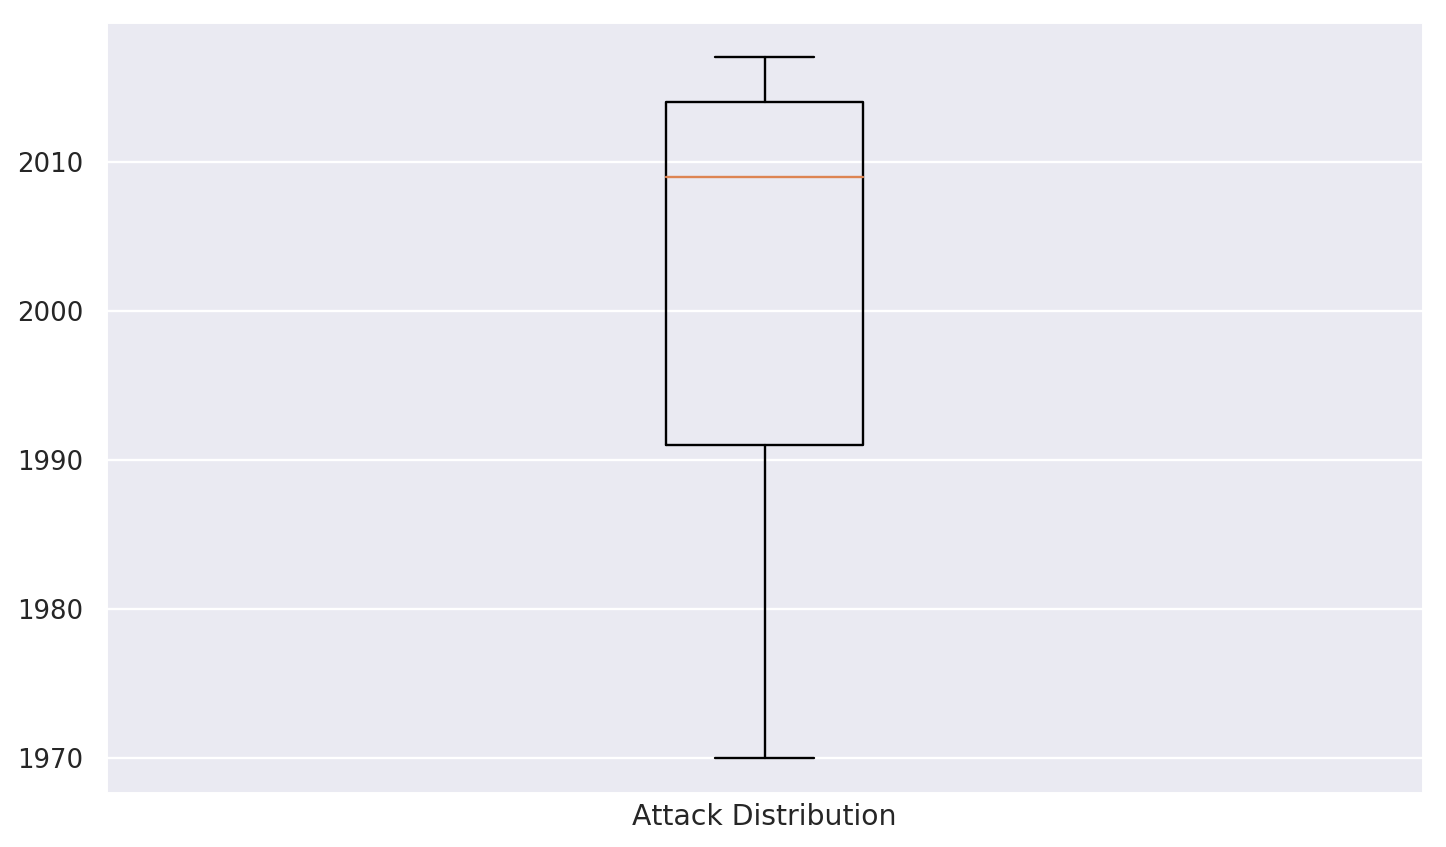

In [9]:
plt.figure(num=None, figsize=(10, 6), dpi=170, facecolor='w', edgecolor='k')
years = data['Year'].tolist()

plt.boxplot(years)
plt.xlabel("Attack Distribution")
plt.xticks([])
plt.show()

We can see that the number of attacks kept growing since 1970, with a relevant growth point starting at the 80's and a massive slope starting in 2012. The peak can be observed in 2014, with almost 17500 attacks. But again, we have to consider what has already been said about the inconstancy of the data. This can best be seen in the boxplot. It is possible to see that half of the attacks are distributed until the year 2010, and the other half between 2010 and 2017.

Lets take a more visual look, and see how these attacks are spread around the world.

In [10]:
fig = plt.figure(num=None, figsize=(6, 4), dpi=170, facecolor='w', edgecolor='k')

event_coord = [(x,l,t,k+w) for [x,l,t,k,w] in data[['Year','Latitude','Longitude','Kills','Wounds']].values]
year_coord = defaultdict(list)
for (x,l,t,c) in event_coord:
    if not math.isnan(l) and not math.isnan(t):
        year_coord[int(x)].append((l,t,c)) 

m = Basemap(projection='cyl', resolution=None,
    llcrnrlat=-90, urcrnrlat=90,
    llcrnrlon=-180, urcrnrlon=180,suppress_ticks=True)    

try:
    m.shadedrelief()
except:
    a=0 
    
markers = 0 

def update(year):
    global markers
    ax = plt.axes()
    ax.set_title("Attacks around the world in "+str(int(year)))
    if markers != 0:
        markers.remove() 
        
    points = [(c,m(y,x)) for x,y,c in year_coord[int(year)]]
    points.sort(reverse=True)
    points = points[0:int(len(points)/10)]
    markers = ax.scatter([x for _,(x,_) in points],[y for _,(_,y) in points],
                         s=[c/7 for c,_ in points],color='red',alpha=0.5,linewidths=0)
    
animation = ani.FuncAnimation(fig, update, sorted(list(year_coord.keys())))

animation.save('map.gif', writer='imagemagick', fps=1)
plt.close(1)

In [11]:
#In case the Basemap library fail to work, open the gif already saved
HTML('<img src="./map.gif">')

This geographical plot is very interesting to check the regions where the attacks have spread over time. Each point represents the geolocalization of a attack, and the point radius represents the number of the attack casualties.

It can be seen that in the early 70's the number of attacks wasn't very representative, and they were. In the 80's a large concentration of attacks was located around central america and north of south america, and the rest of them can be clustered in southern Africa, Middle East and India. From there, there's a certain constant pattern that could be noted, where the majority of attacks are distributed between northern Africa and the Middle East.

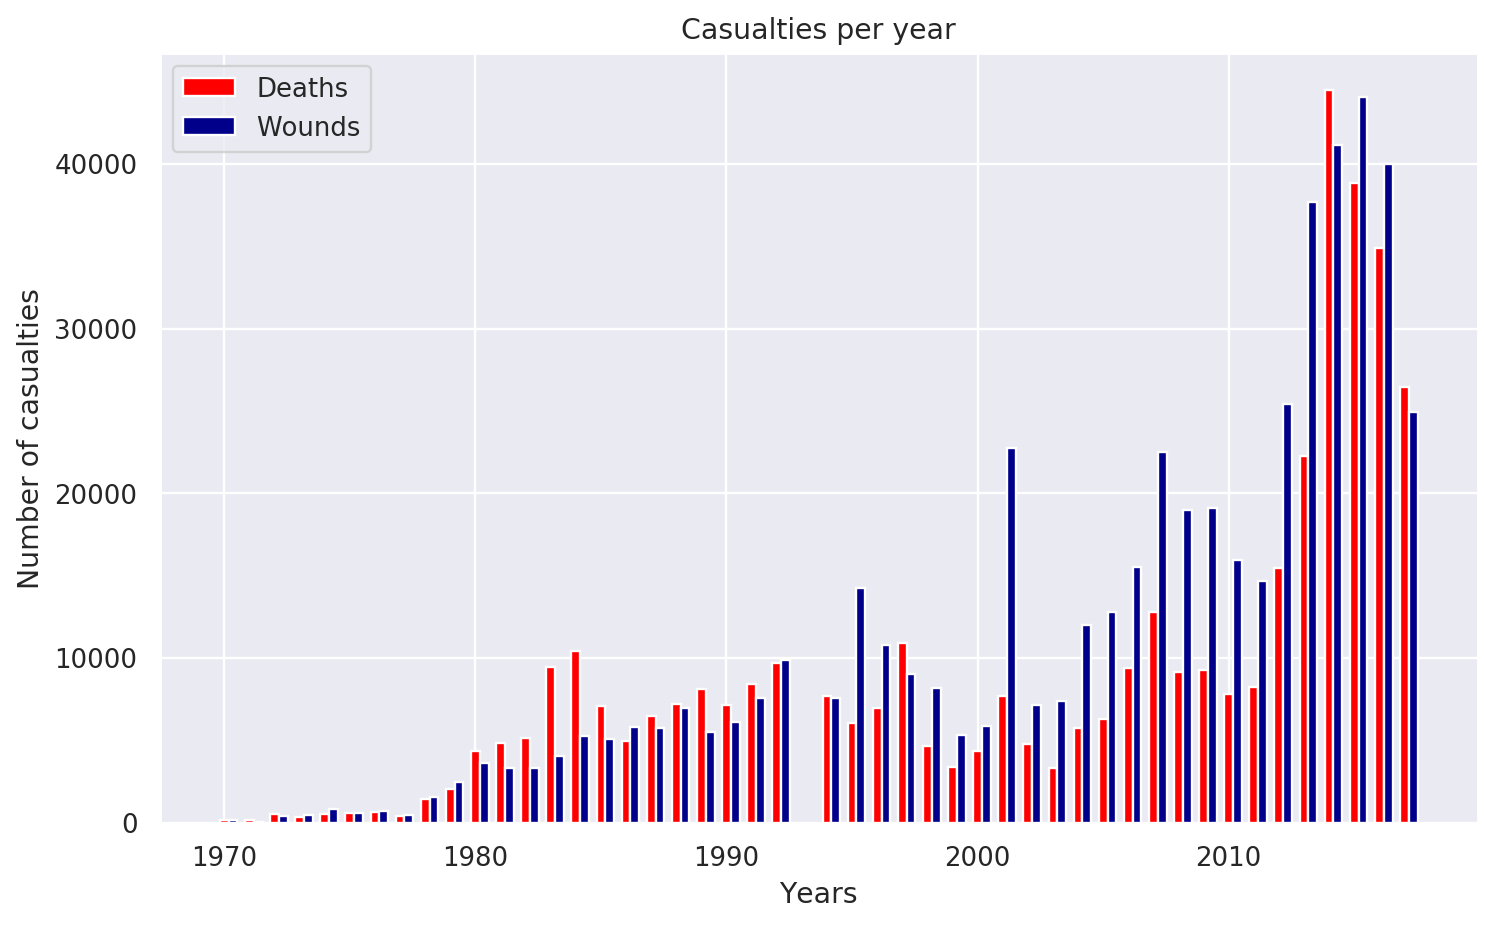

In [12]:
year_dw = data.groupby(['Year'])['Kills','Wounds'].sum()

plt.figure(num=None, figsize=(10, 6), dpi=170)
plt.bar(year_dw.index,year_dw['Kills'],0.35,color='red')
plt.bar(year_dw.index+0.35,year_dw['Wounds'],0.35,color='darkblue')
plt.xlabel('Years')
plt.ylabel('Number of casualties')
plt.title('Casualties per year')
plt.legend(('Deaths','Wounds'))
plt.show()

As we can see, the number of casualties follows the same pattern as the number of attacks, with a steady growth, and a huge peak in the last 5 years. One interesting thing to note is that the data give the impression that, in the 1980s the attacks used to be more lethal, as for a few years at the beginning of the decade, the death toll was greater than the number of wounded.

These information becomes clearer when we look at annual averages.

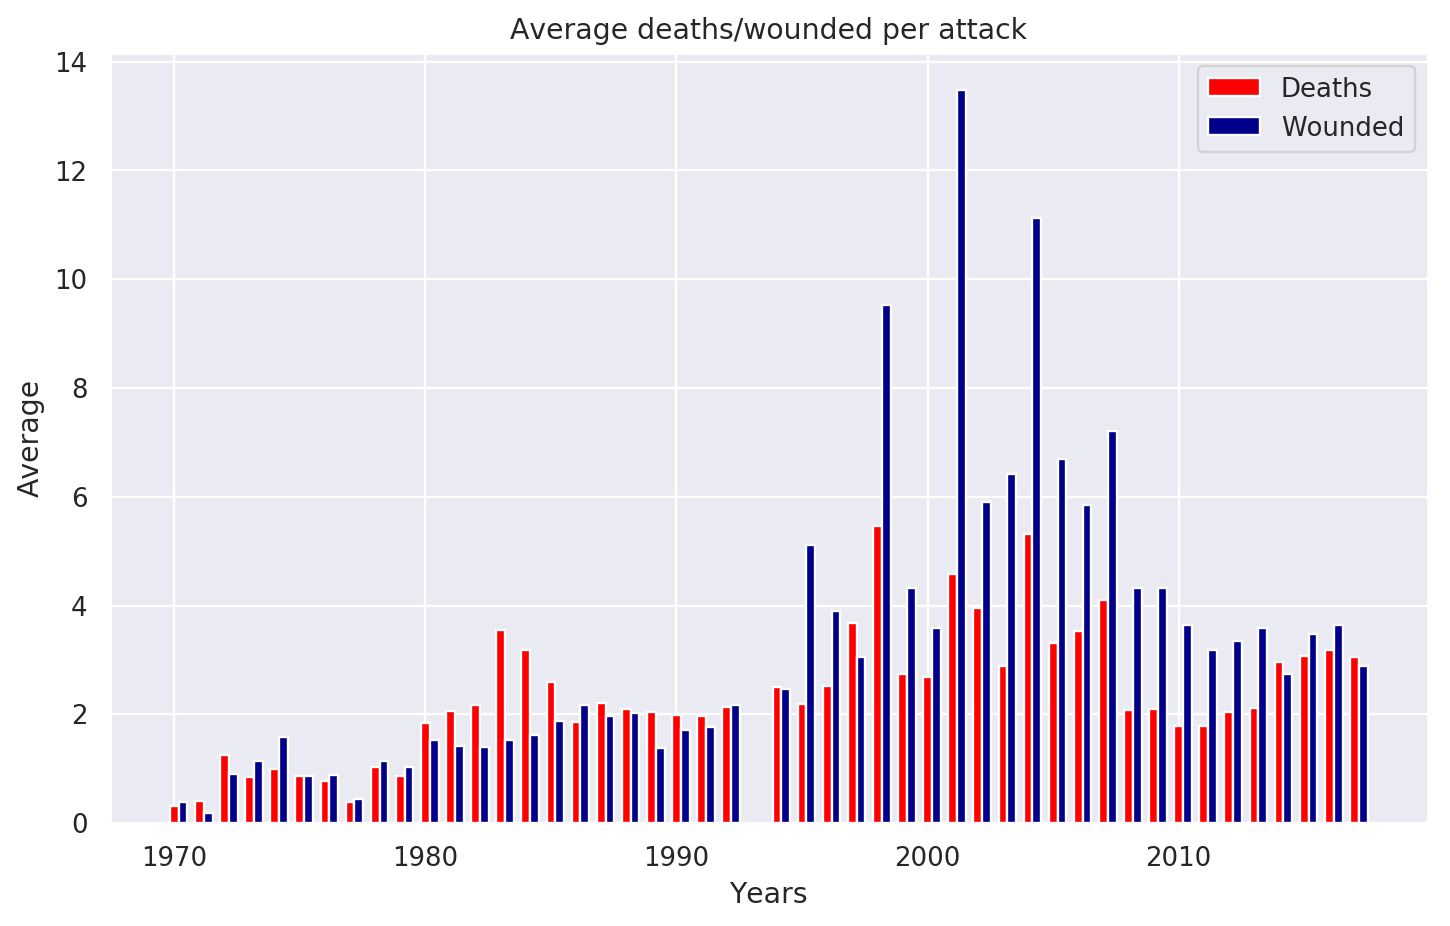

In [13]:
year_dw = data.groupby(['Year'])['Kills','Wounds'].sum()

year_count = data[data['Success']==1].groupby(['Year']).size().reset_index(name='Attacks').set_index('Year')

plt.figure(num=None, figsize=(10, 6), dpi=170, facecolor='w', edgecolor='k')
plt.bar(year_dw.index,year_dw['Kills']/year_count['Attacks'],0.35,color='red')
plt.bar(year_dw.index+0.35,year_dw['Wounds']/year_count['Attacks'],0.35,color='darkblue')
plt.xlabel('Years')
plt.ylabel('Average')
plt.title('Average deaths/wounded per attack')
plt.legend(('Deaths','Wounded'))
plt.show()

With the averages we now can see that the huge number of victims in the last five years is formed by the huge number of attacks, and not by a greater number of victims per attack.

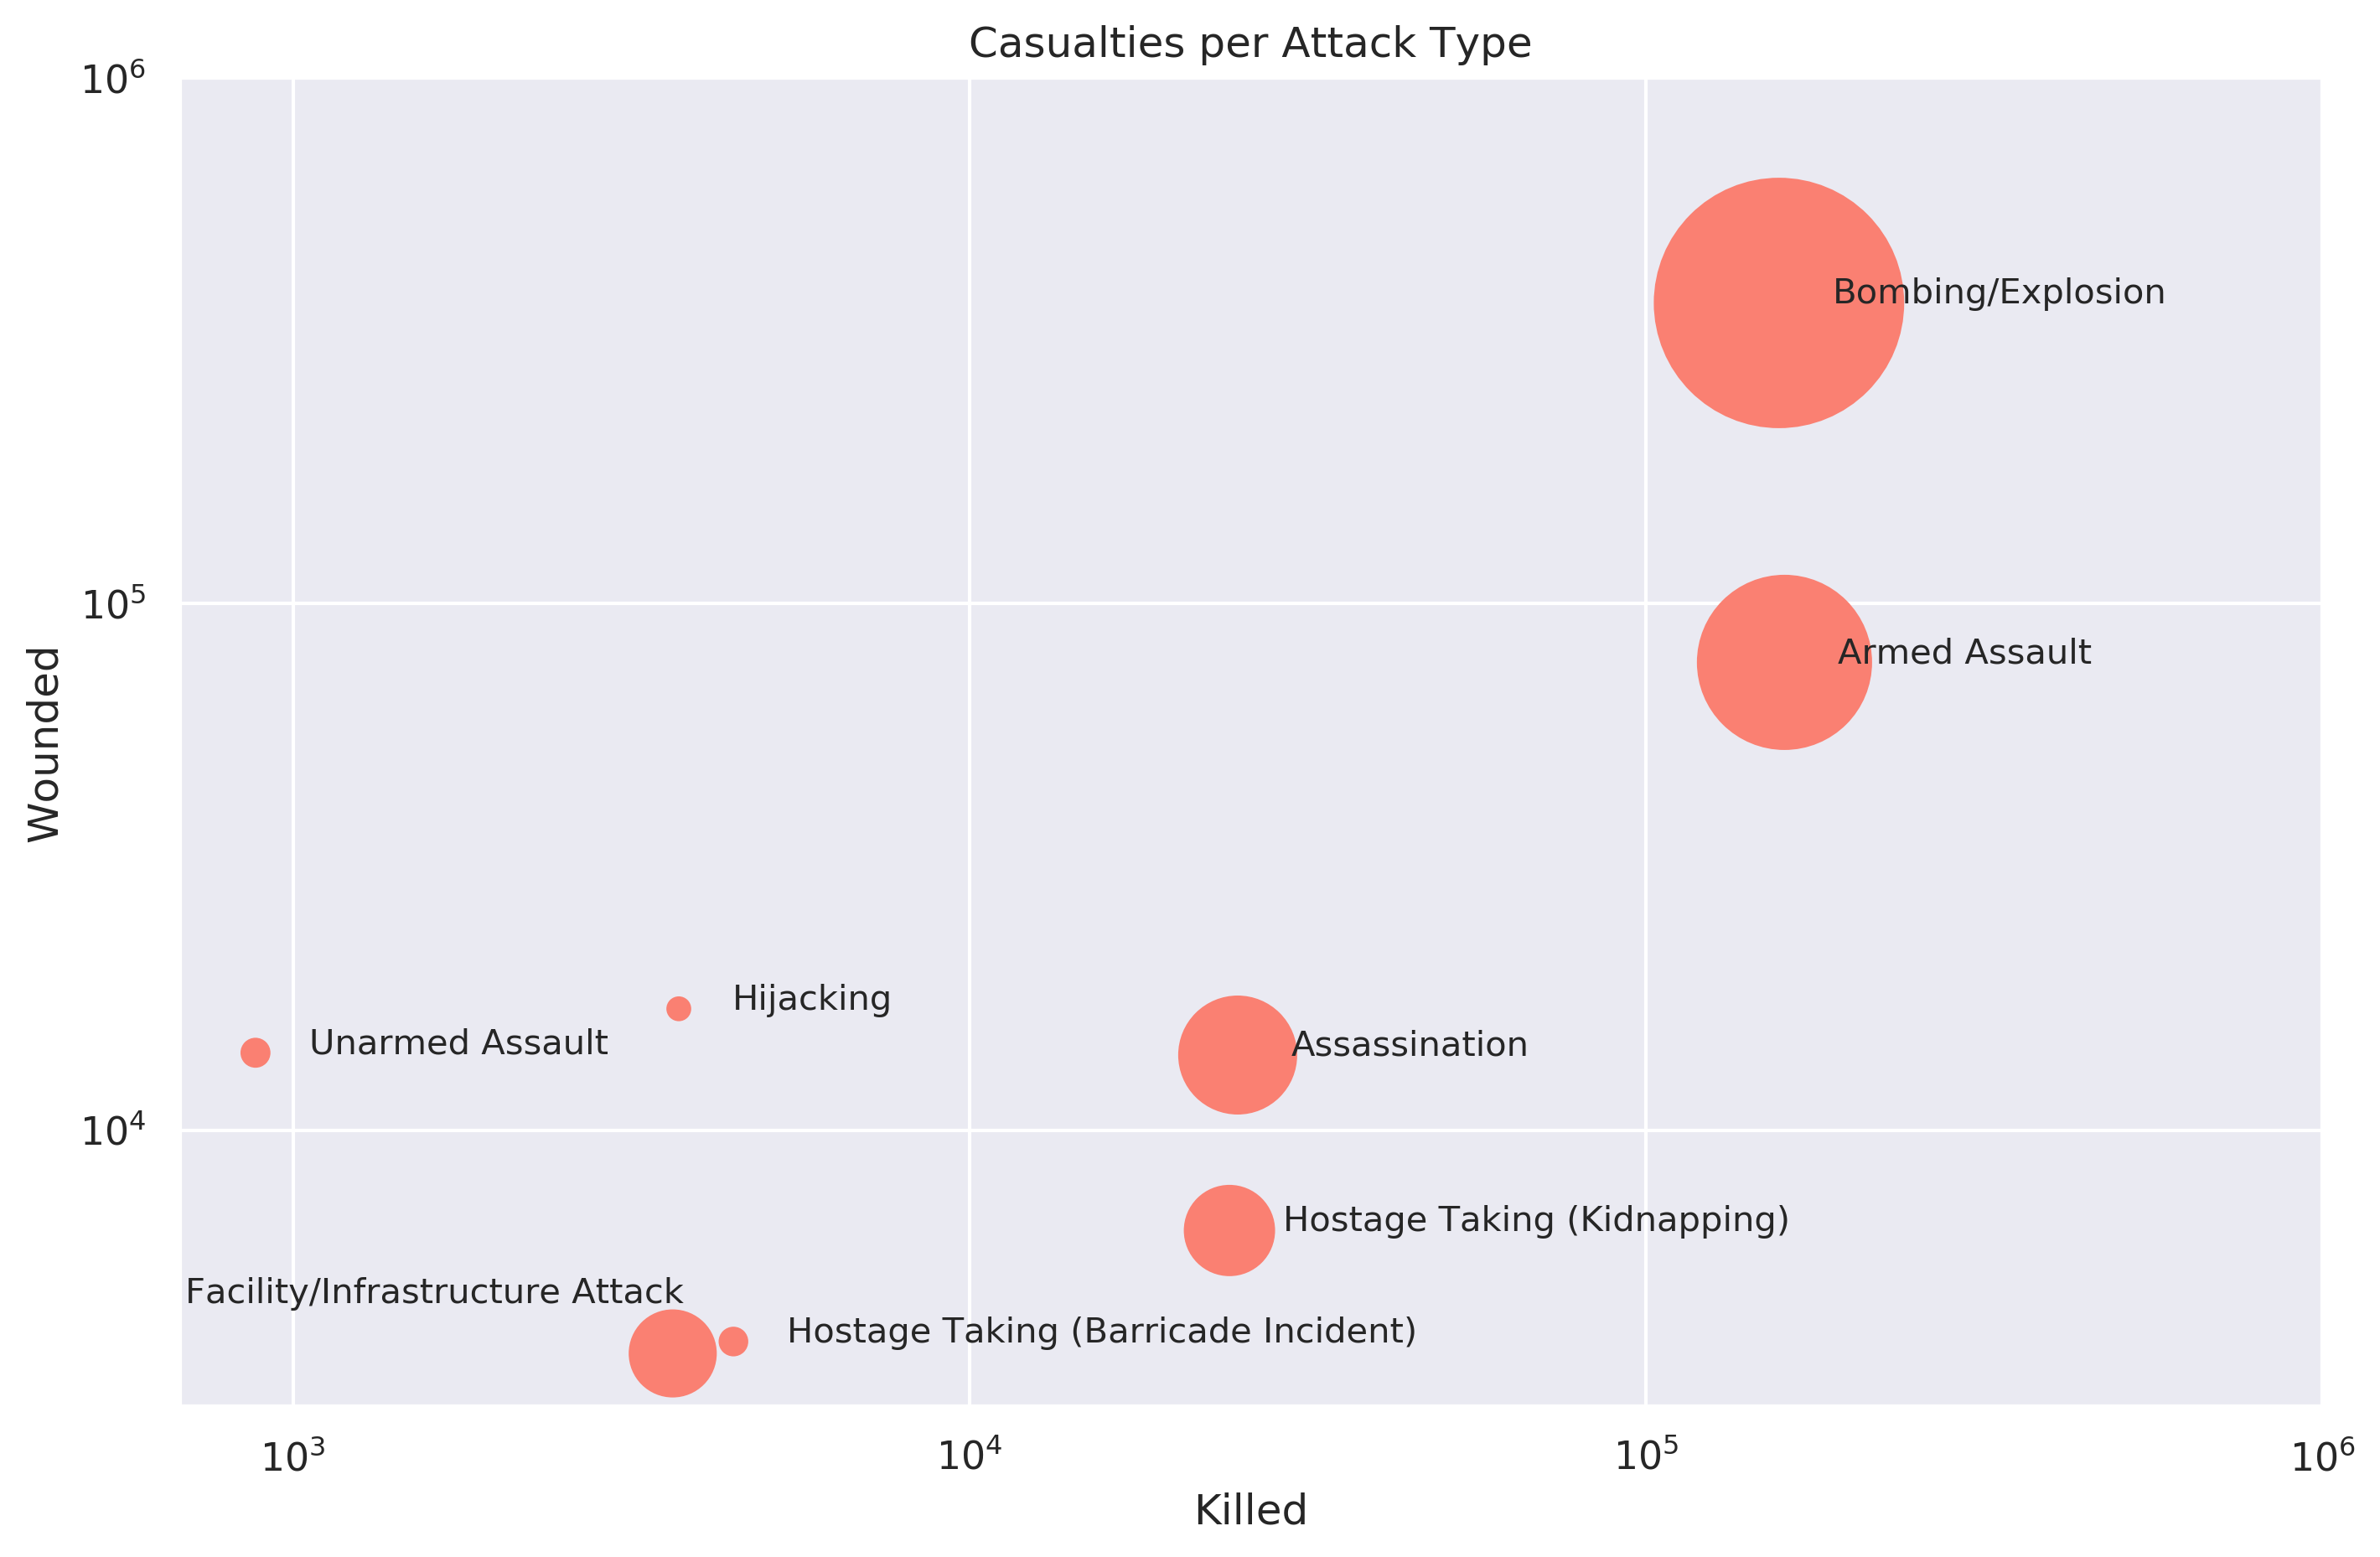

In [14]:
fig = plt.figure(num=None, figsize=(11, 7), dpi=300, facecolor='w', edgecolor='k')

att_kw = data.groupby(['AttackType'])['Kills','Wounds'].sum()
att_n = data.groupby(['AttackType']).size().reset_index(name='Number').set_index('AttackType')

att_kw.drop(['Unknown'],inplace=True)
att_n.drop(['Unknown'],inplace=True)

ax = plt.axes()
plt.scatter(att_kw['Kills'],att_kw['Wounds'],s=(att_n['Number']/max(att_n['Number'])*5000),color='salmon')

for index in att_kw.index:
    if not index.startswith('Fa'):
        ax.annotate(index,xy=(att_kw.loc[index]['Kills']*1.2,
                          att_kw.loc[index]['Wounds']),fontsize=10)
    else:
        ax.annotate(index,xy=(att_kw.loc[index]['Kills']*0.19,
                          att_kw.loc[index]['Wounds']*1.25),fontsize=10)
        
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Killed')
plt.ylabel('Wounded')
plt.title('Casualties per Attack Type')
plt.xlim((0,10**6))
plt.ylim((0,10**6))
plt.show()

When looking at the attack types, the most dangerous ones seems to be Bombings and Armed Assaults, as they are the ones with the most number of records (circle radius) and with the greater number of casualties. However, the two types of hostage-taking and kidnappings stand out because they are categories with a relatively small number of records, but still with a large number of reported victims (especially those of barricade incidents and kidnappings). Being types of attack in which the main objective is not always to cause harm to the victims, it was not expected a casualty rate that big.

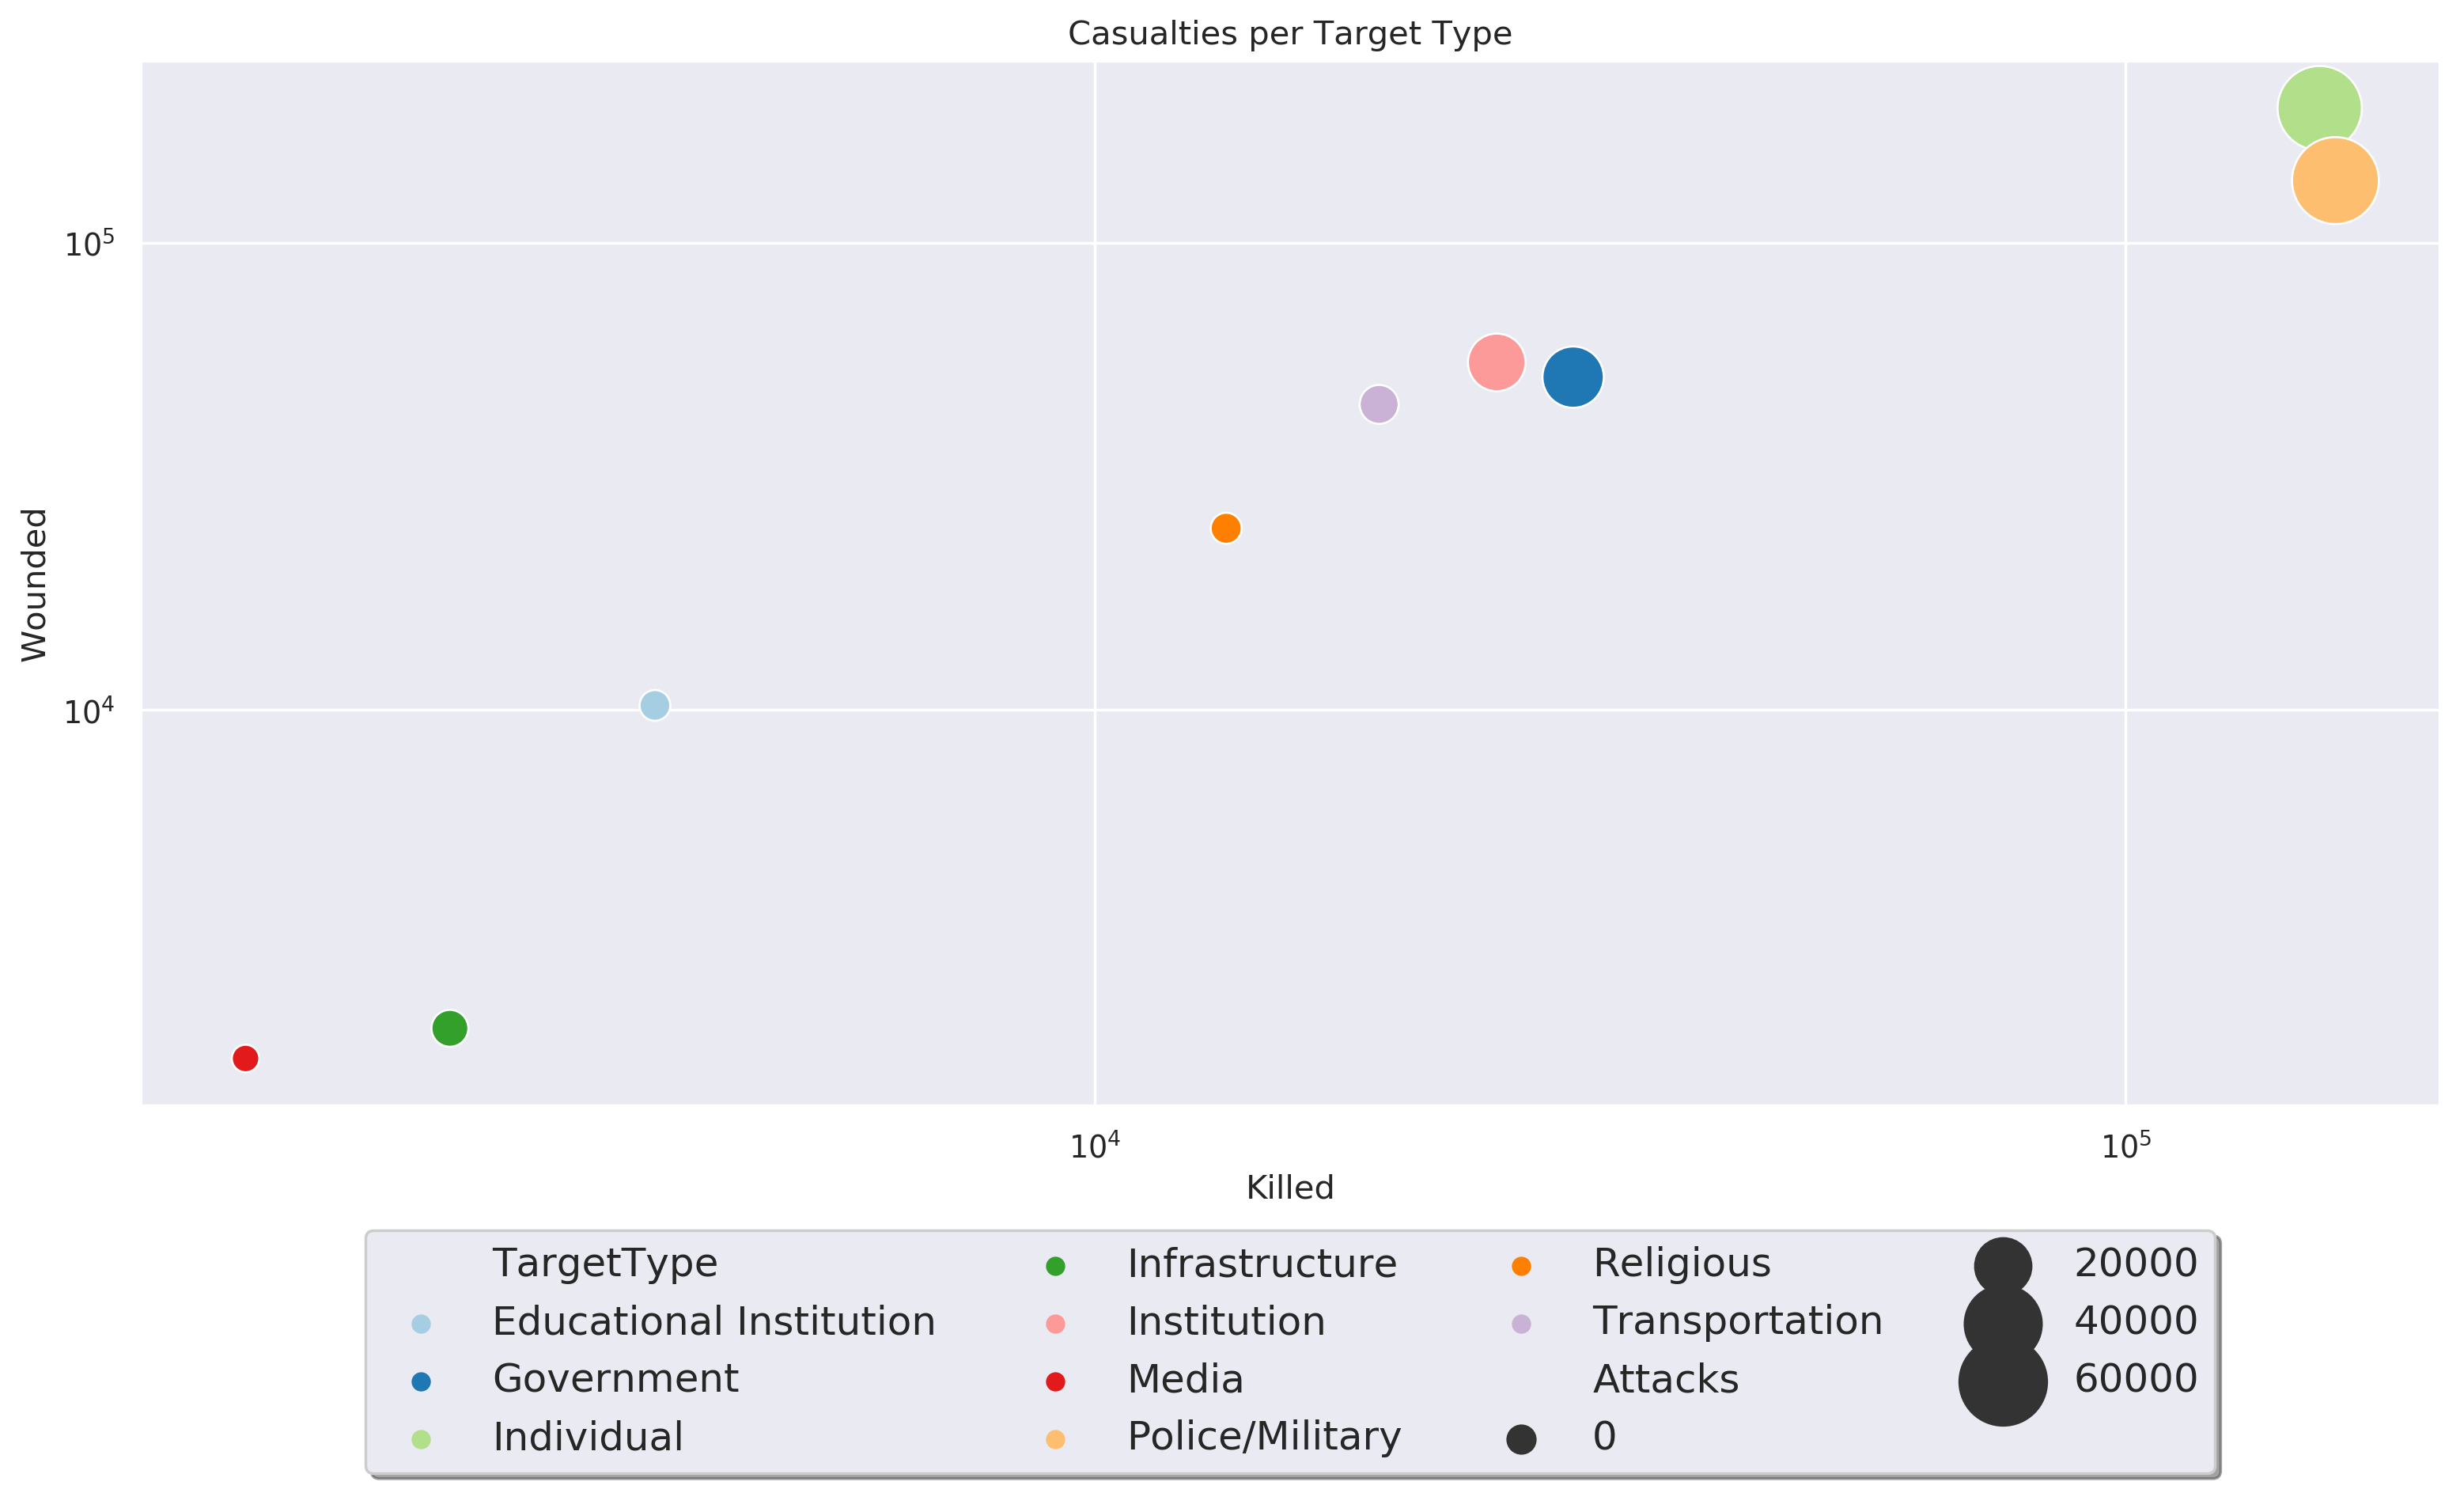

In [15]:
fig = plt.figure(num=None, figsize=(15, 7), dpi=250, facecolor='w', edgecolor='k')

att_kw = data.groupby(['TargetType'])['Kills','Wounds'].sum()
att_n = data.groupby(['TargetType']).size().reset_index(name='Number').set_index('TargetType')
att_kw = att_kw.assign(Attacks=att_n)

att_kw.drop(['Unknown'],inplace=True)
att_n.drop(['Unknown'],inplace=True)

att_kw.reset_index(inplace=True)
sns.set_palette(sns.color_palette("Paired",22))
ax = sns.scatterplot(x='Kills', y= 'Wounds',hue='TargetType',
                     size='Attacks',sizes=(100,1000),data=att_kw)
ax.set(xscale="log", yscale="log",xticks=(0,10**6),yticks=(0,10**6))
ax.set_xlabel('Killed')
ax.set_ylabel('Wounded')
ax.set_title('Casualties per Target Type')
lgd=ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10),
          fancybox=True, shadow=True, ncol=4,
          fontsize='large')

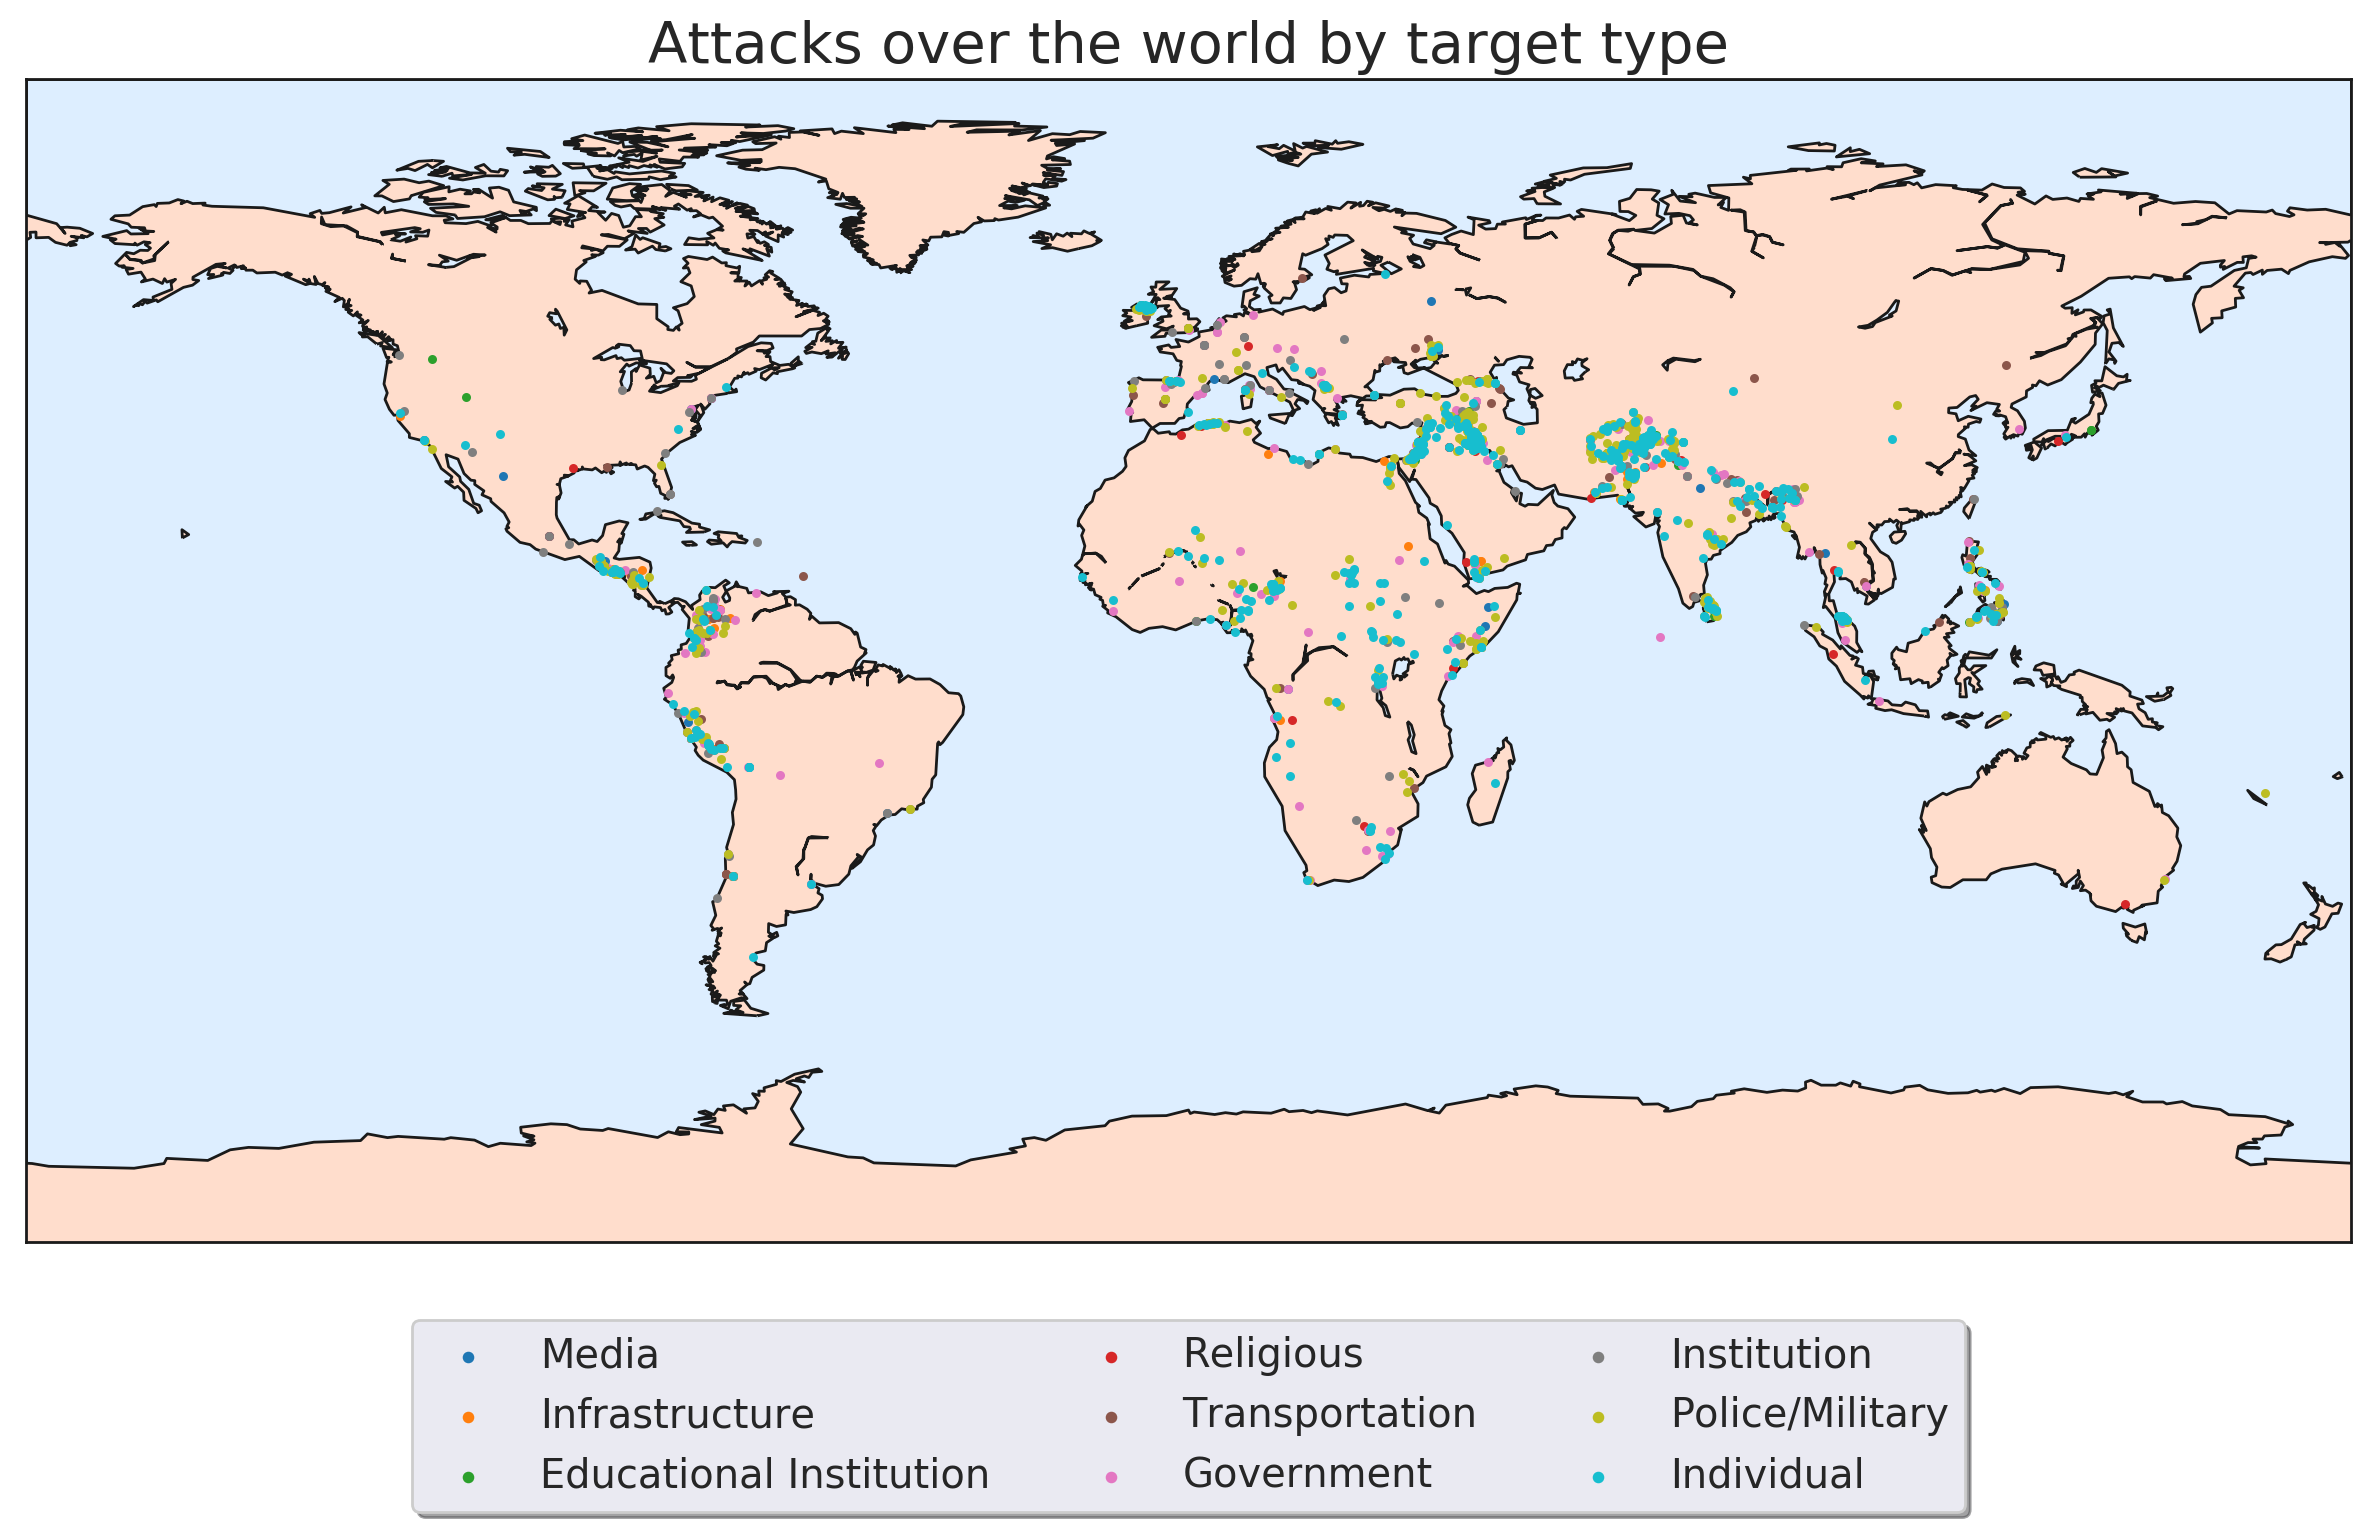

In [39]:
fig = plt.figure(figsize=(15, 10), dpi=200, facecolor='w', edgecolor='k')

att_kw = data.groupby(['TargetType'])['Kills','Wounds'].sum()
att_n = data.groupby(['TargetType']).size().reset_index(name='Number').set_index('TargetType')
att_kw = att_kw.assign(Attacks=att_n)

att_kw.drop(['Unknown'],inplace=True)
att_n.drop(['Unknown'],inplace=True)

event_coord = [(x,l,t) for [x,l,t] in data.sample(2000)[['TargetType','Latitude','Longitude']].values]
tartype_coord = defaultdict(list)
for (x,l,t) in event_coord:
    if x in att_kw.index and (l != 0  or t!=0):
        tartype_coord[x].append((l,t)) 

m = Basemap(projection='cyl',
    llcrnrlat=-90, urcrnrlat=90,
    llcrnrlon=-180, urcrnrlon=180)    

ax = plt.axes()
ax.set_title("Attacks over the world by target type",
          fontsize='xx-large')

m.fillcontinents(color="#FFDDCC", lake_color='#DDEEFF',ax=ax)
m.drawmapboundary(fill_color="#DDEEFF")
m.drawcoastlines()

colors = iter(cm.tab10(np.linspace(0, 1, len(tartype_coord.keys()))))

att_kw.sort_values(by=['Wounds'],inplace=True)

for key in att_kw.index:
    points = [m(y,x) for x,y in tartype_coord[key]]
    ax.scatter([x for x,_ in points],[y for _,y in points],s=5,label=key,zorder=2,color=next(colors))

lgd = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=3,
          fontsize='large')
for handle in lgd.legendHandles:
    handle.set_sizes([10.0])
    
#plt.show()
fig = ax.get_figure()
fig.savefig('map_attacktype.jpg')

The casualty charts by target type shows a shocking reality. The type of target most targeted and attained by the terrorist attacks is the one formed by common individuals, followed by attacks against military and the police, and attacks against governments. On the map, we can see that these types of targets are harmed all around the world, showing a large number of occurrences in each visually perceptible cluster. This shows a sad reality in which even individuals who have nothing to do with the motivations of terrorist groups can be threatened by the attacks, and even risk losing their lives in vain.


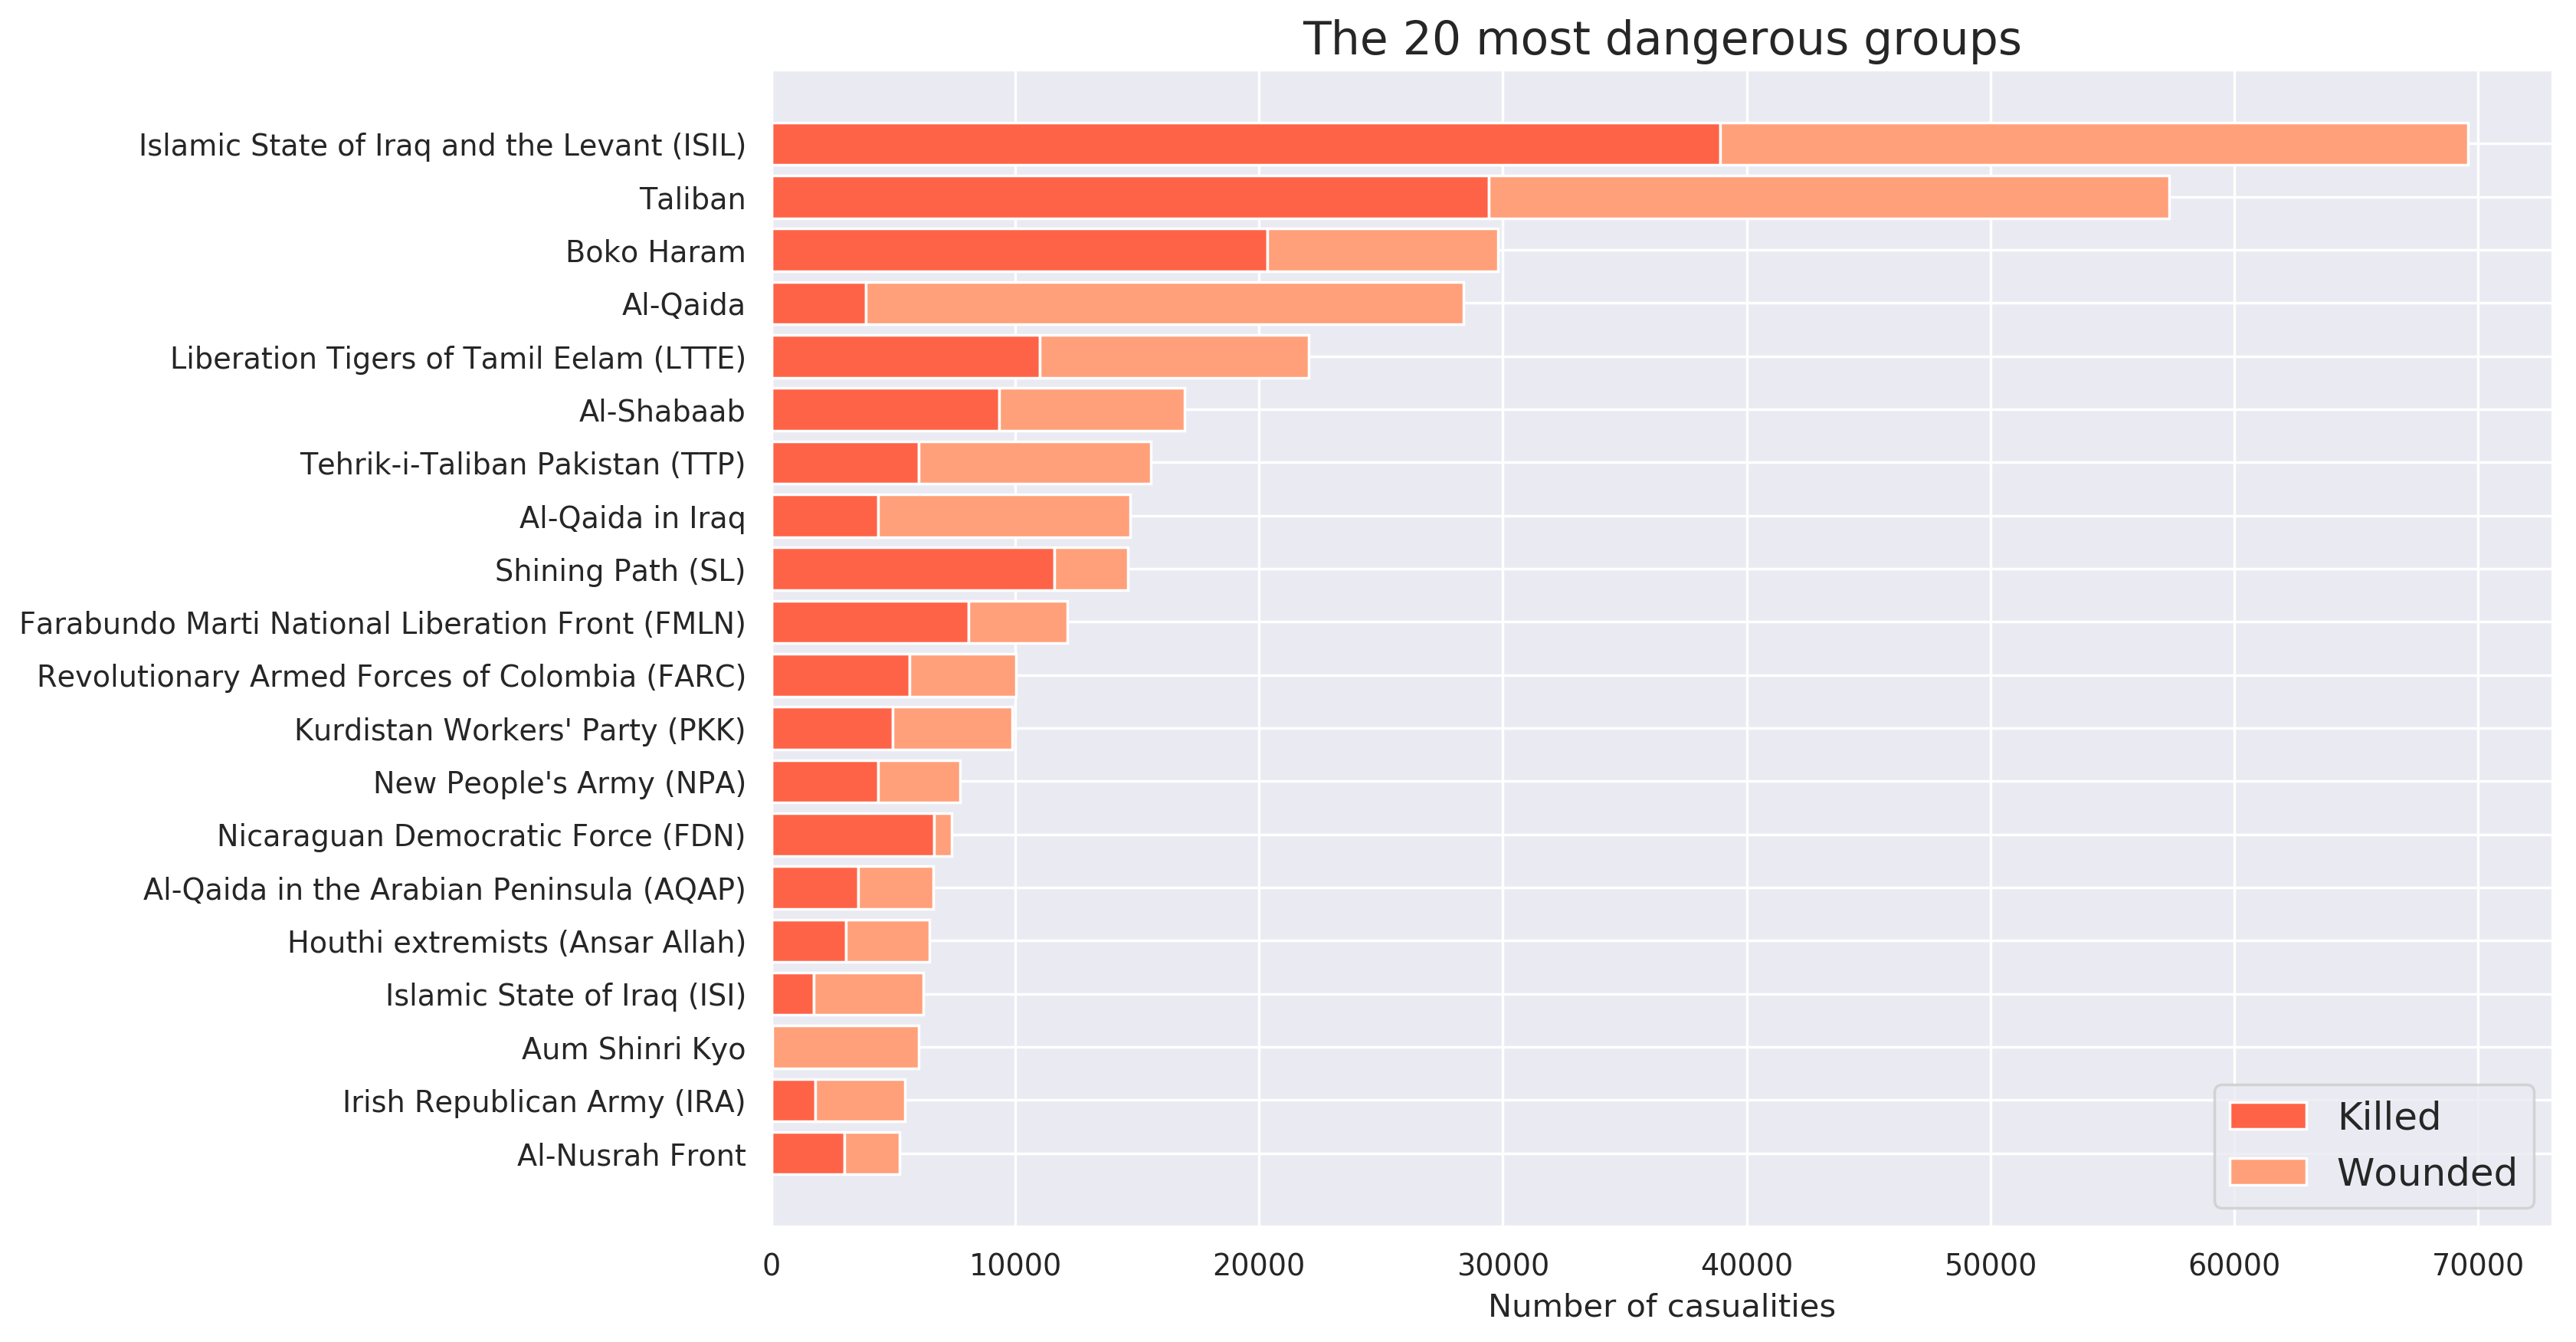

In [17]:
fig = plt.figure( figsize=(12, 8), dpi=250, facecolor='w', edgecolor='k',frameon=True)

group_kw = data.groupby(['Group'])['Kills','Wounds'].sum()
group_n = data.groupby(['Group']).size().reset_index(name='Attacks').set_index('Group')
group_kw = group_kw.assign(casualties=group_kw.sum(axis=1))

group_kw.drop(['Unknown'],inplace=True)
group_n.drop(['Unknown'],inplace=True)

group_n = group_n.sort_values(by=['Attacks'],ascending=False).head(20)
group_kw = group_kw.sort_values(by=['casualties'],ascending=False).head(20)

group_kw.sort_values(by=['casualties'],inplace=True)

plt.barh(group_kw.index,group_kw['Kills'],color='tomato')
plt.barh(group_kw.index,group_kw['Wounds'],left=group_kw['Kills'],color='lightsalmon')
plt.xlabel("Number of casualities")
plt.legend(("Killed","Wounded"),fancybox=True,
          fontsize='large')
plt.title("The 20 most dangerous groups",fontsize='x-large')
fig.savefig('casualties_per_group.png')
plt.show()

In [18]:
event_coord = [(x,l,t) for [x,l,t] in data[['Group','Latitude','Longitude']].values]
group_coord = defaultdict(list)
for (x,l,t) in event_coord:
    if x in group_kw.index and (l != 0  or t!=0):
        group_coord[x].append((l,t)) 

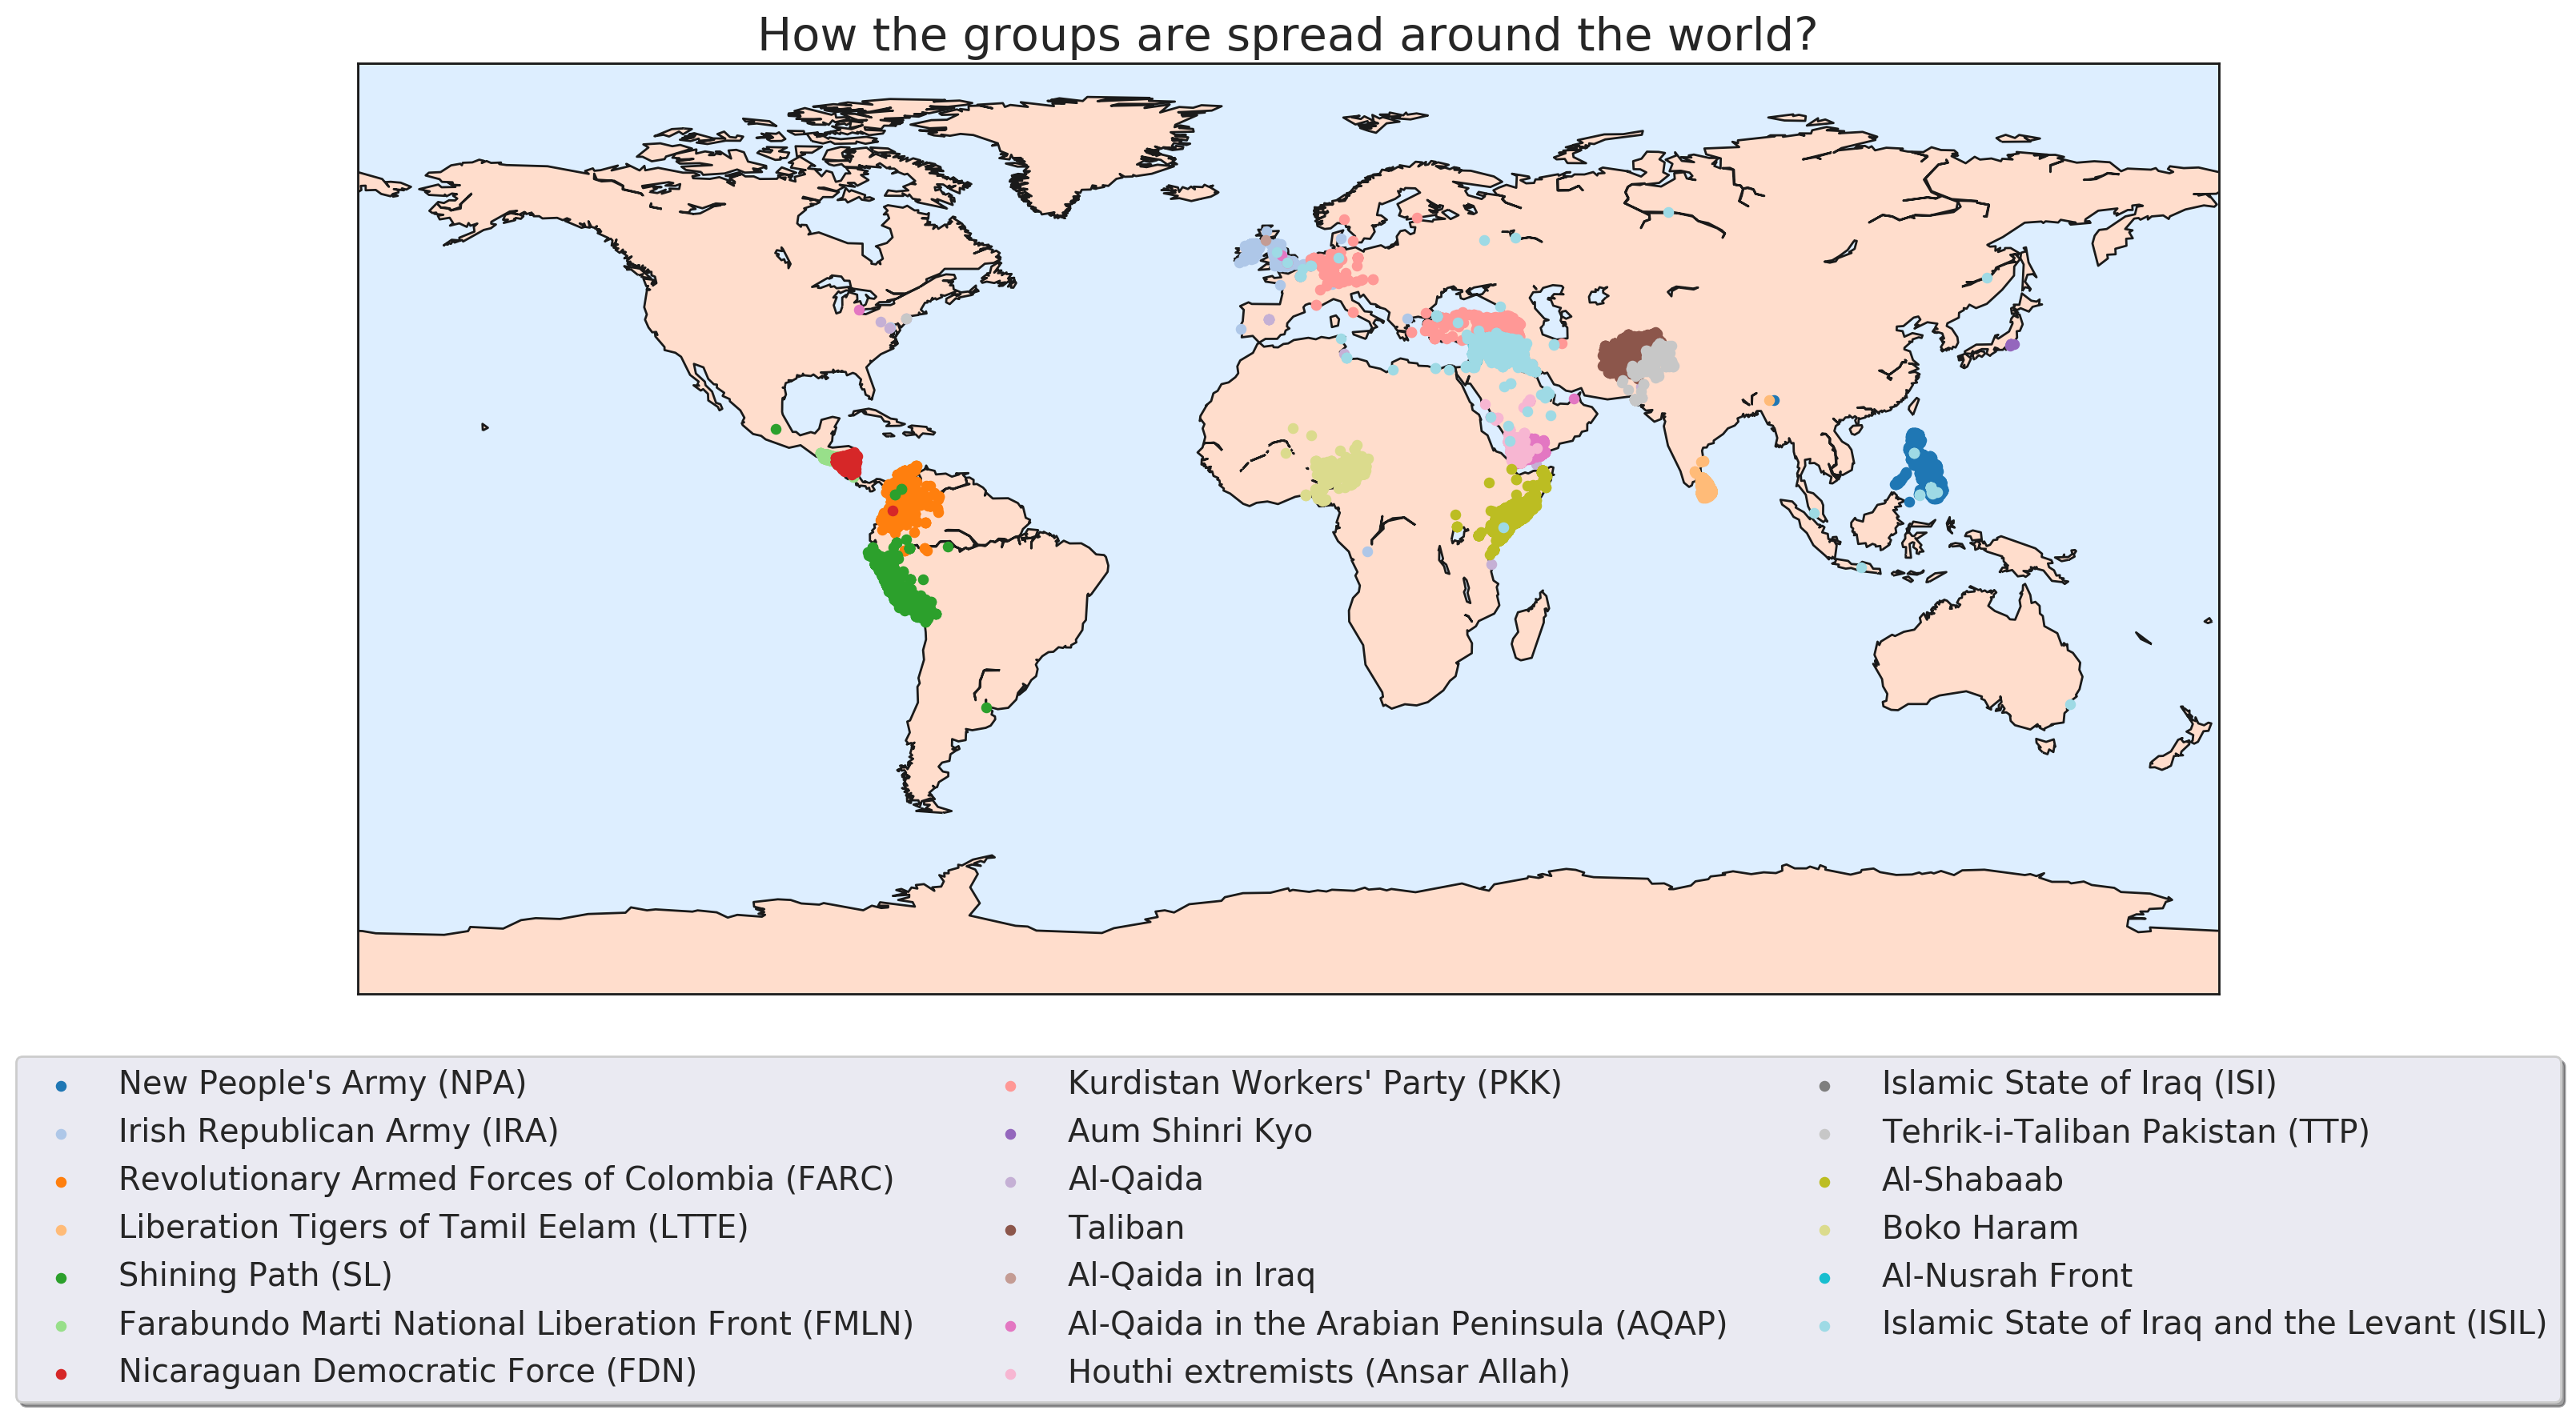

In [43]:
fig = plt.figure(figsize=(15, 10), dpi=200, facecolor='w', edgecolor='k')

m = Basemap(projection='cyl',
    llcrnrlat=-90, urcrnrlat=90,
    llcrnrlon=-180, urcrnrlon=180)    

ax = plt.axes()
ax.set_title("How the groups are spread around the world?",
          fontsize='xx-large')

m.fillcontinents(color="#FFDDCC", lake_color='#DDEEFF',ax=ax)
m.drawmapboundary(fill_color="#DDEEFF")
m.drawcoastlines()

colors = iter(cm.tab20(np.linspace(0, 1, len(group_coord.keys()))))
for key in group_coord.keys():
    points = [m(y,x) for x,y in group_coord[key]]
    ax.scatter([x for x,_ in points],[y for _,y in points],s=15,label=key,zorder=10,color=next(colors))

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=3,
          fontsize='large')

#plt.show()
fig = ax.get_figure()
fig.savefig('map_groups.jpg', bbox_inches='tight')

At last, it would be useful to analyze the largest groups recorded by the database. That way, the first graph shows the 20 largest groups, ordered by the number of attacks, at the same time that it informs the number of deaths and injured caused by the group in the analyzed time span. The map shows the geographical distribution of these groups, showing a sample of attacks labeled by which group was responsible.

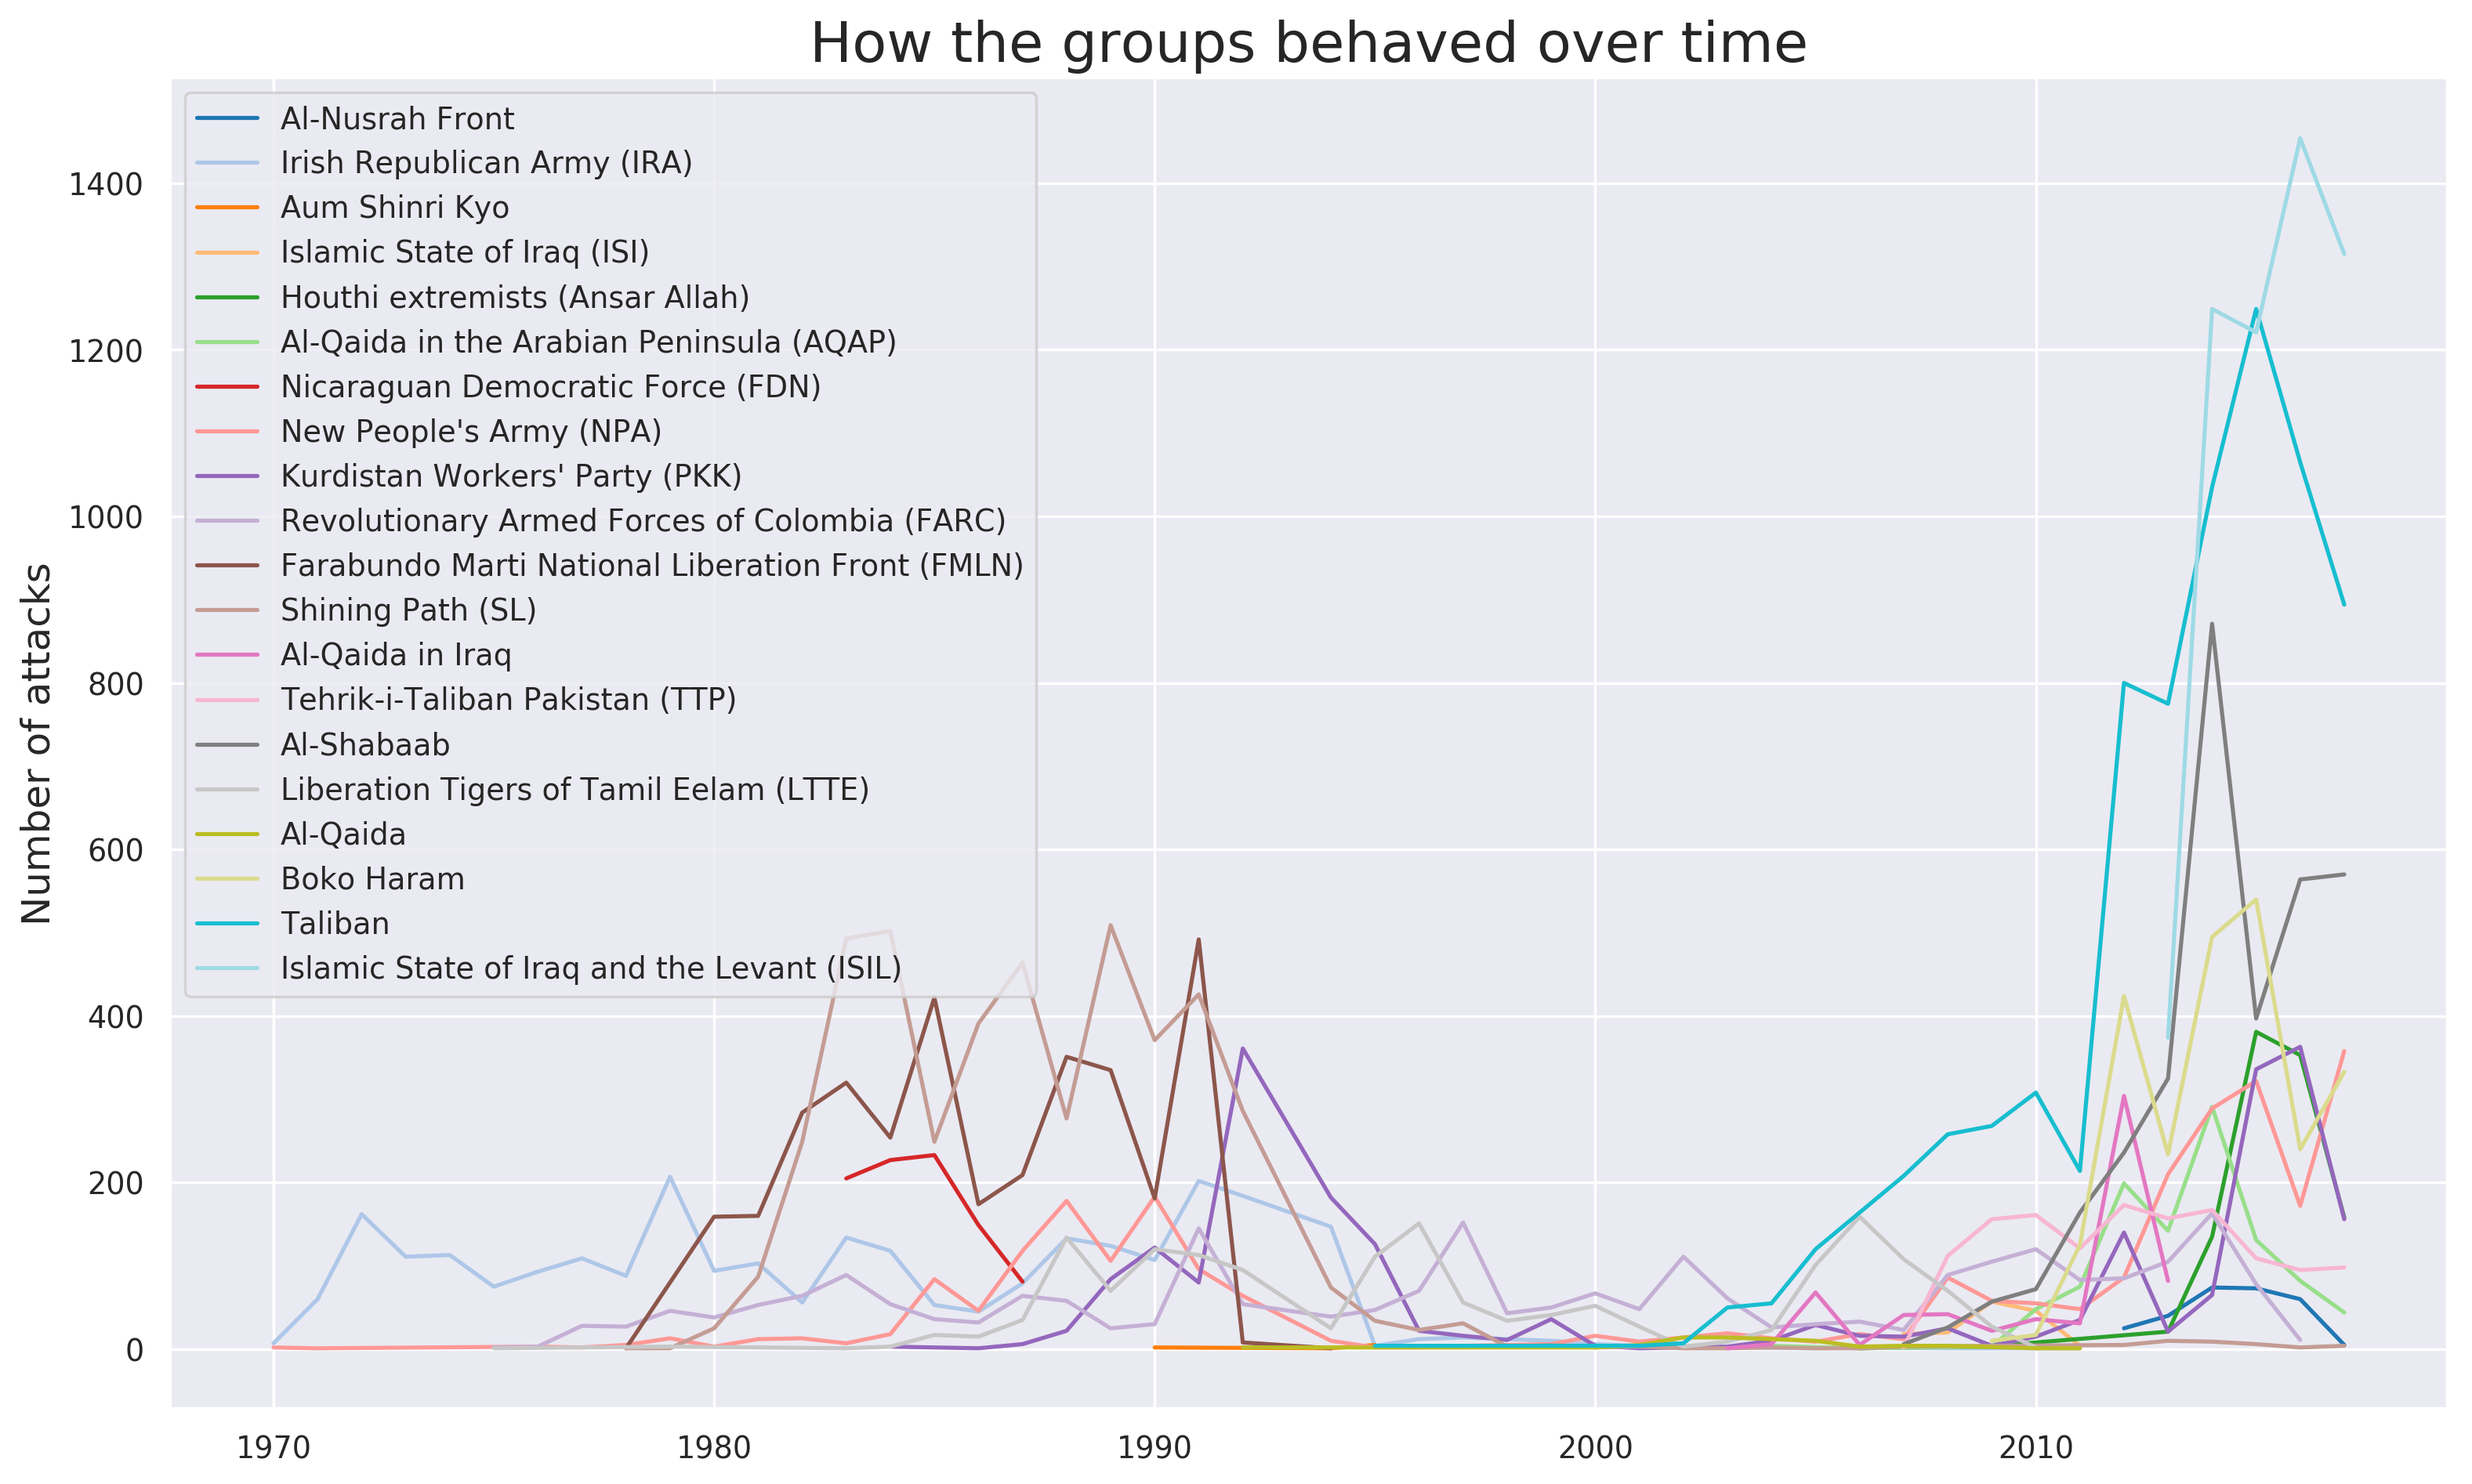

In [20]:
group_year_n = data.groupby(['Group','Year']).size().reset_index(name='Attacks').set_index('Group')

group_year_n = group_year_n.loc[group_kw.index.values]

fig = plt.figure(figsize=(15, 9), dpi=250, facecolor='w', edgecolor='k')

colors = iter(cm.tab20(np.linspace(0, 1, len(group_coord.keys()))))
for key in group_kw.index.values:
    plt.plot(group_year_n.loc[key]['Year'],
            group_year_n.loc[key]['Attacks'],
            label=key, color = next(colors))
    
plt.title("How the groups behaved over time",fontsize='xx-large')
plt.ylabel('Number of attacks',fontsize='large')
plt.legend(fancybox=True,)
plt.show()

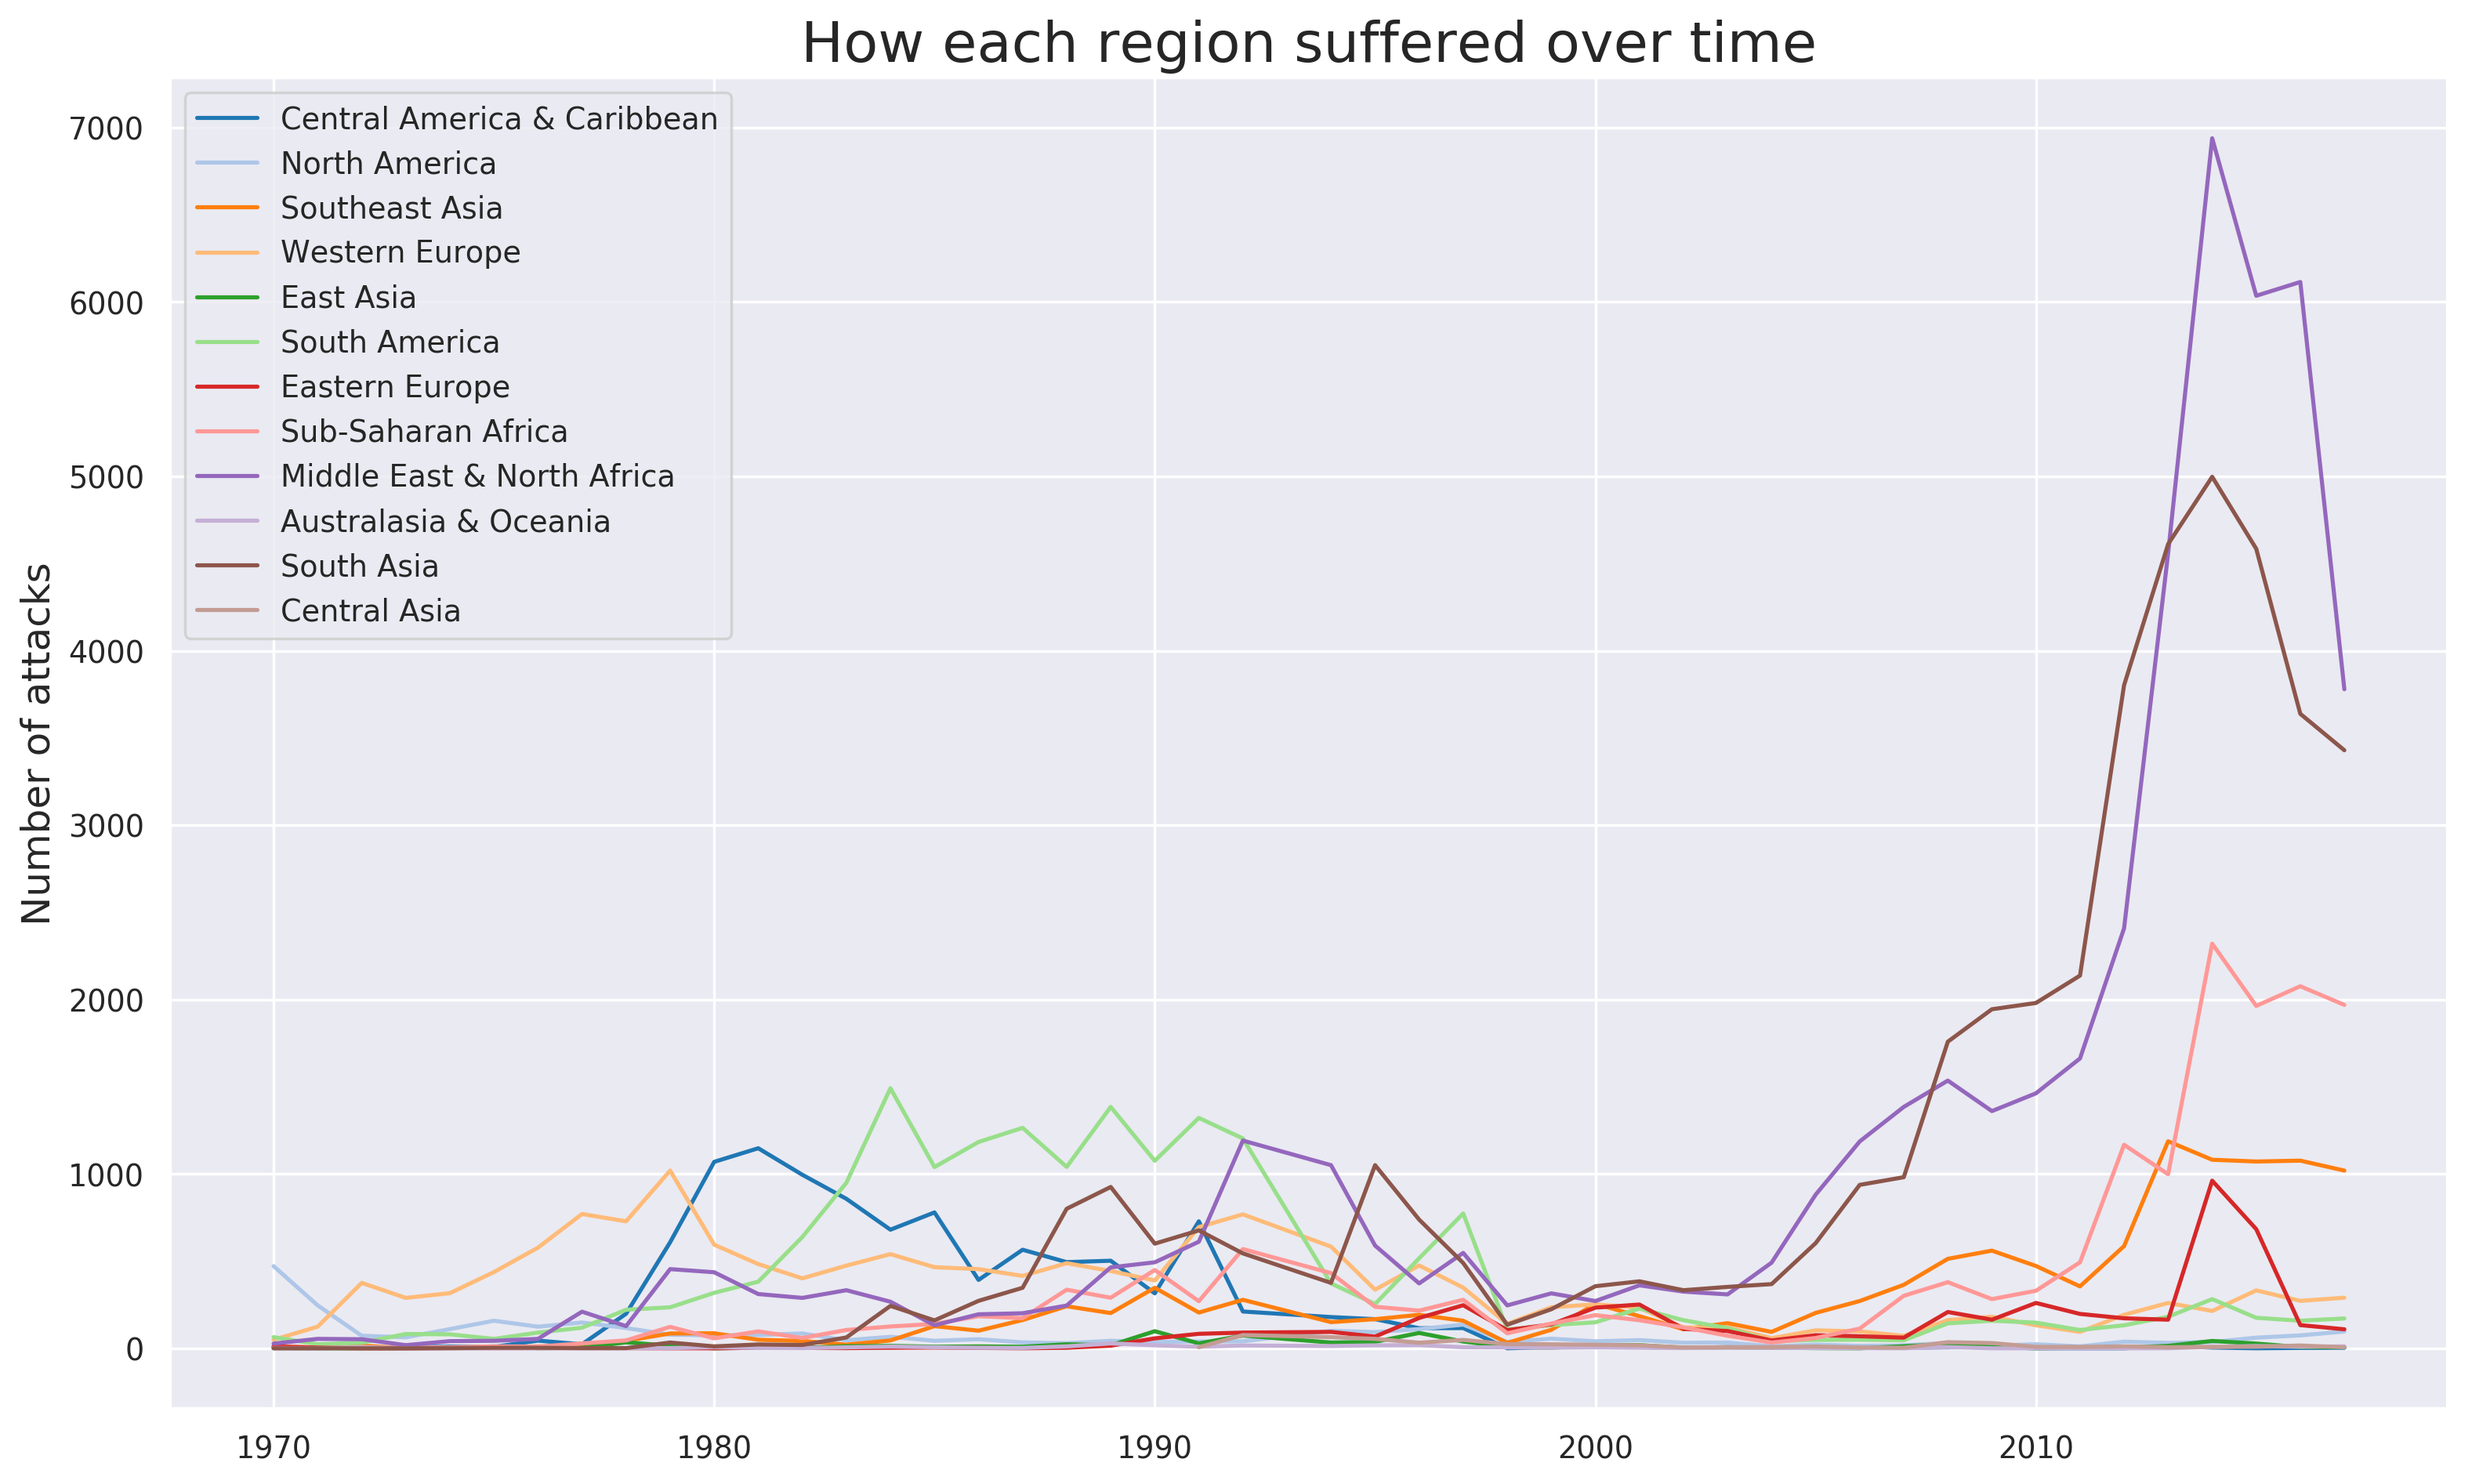

In [21]:
region_year_n = data.groupby(['Region','Year']).size().reset_index(name='Attacks').set_index('Region')

fig = plt.figure(figsize=(15, 9), dpi=250, facecolor='w', edgecolor='k')

colors = iter(cm.tab20(np.linspace(0, 1, len(group_coord.keys()))))
for key in data['Region'].unique():
    plt.plot(region_year_n.loc[key]['Year'],
            region_year_n.loc[key]['Attacks'],
            label=key, color = next(colors))
    
plt.title("How each region suffered over time",fontsize='xx-large')
plt.ylabel('Number of attacks',fontsize='large')
plt.legend(fancybox=True,)
plt.show()

The last two graphs show the trend of groups and attacks by world region. These graphs show a clear division of the groups' behavior through time, in which over the 80's and the 90's, the marjority of the attacks were by South and Central American groups, like the FARC and the Shining Path. Past the 2000's, the trend has shifted to the  Middle East, North Africa, and South Asia groups, represented by famous groups nowadays such as Boko Haram, Taliban and the Islamic State.

## Conclusions

As has already been said, terrorism is still a very delicate subject to deal with today, which has made this subject a taboo. However, such project proved to be very enriching, as it was an interesting way of informing and making people aware of some data that may be invisible to the general public. As can be seen from the analysis, the tendency is for the attacks to continue growing, with the appearance of more and more groups, which in the end generates an almost certain result: the death of several innocent people in this war scenario.

The analysis could also show some patterns that have not been very well defined, like the existence of target groups and regions more susceptible to attacks. But still, I think that there exists so much to be discovered with deeper analysis, which can take more time and work. The discovery of probabilistic and statistical patterns through attack characterization, or a learning model that can classify the final outcome of an attack, can be very interesting results to be sought in future work.

## References

GTD Web Page - https://www.start.umd.edu/gtd/

Kaggle's GTD mirror - https://www.kaggle.com/START-UMD/gtd